In [77]:
# Import required packages

import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap, BoundaryNorm
from shapely.geometry import Point
from numpy import trapz
from scipy.stats import gamma,norm,fisk
from sklearn.cluster import KMeans
import sys
from pathlib import Path
import logging

# Add project root to path
project_root = Path.cwd().parent.parent
sys.path.append(str(project_root))


In [2]:
# Configuration
config = {
    'casr_input_data': project_root / 'data' / 'output_data' / 'merged_2d' / '1980_2024'/'bow_combined_full_data.csv',
    'SPEI_input_data': project_root / 'data' / 'output_data' / 'merged_2d' / '1980_2024'/'SPEI'/'bow_combined_SPEI_data.csv',
    'shapefile': project_root / 'data' / 'input_data' / 'shapefiles'/'BowRiverBasin'/'Bow_elevation_combined.shp',
    'canswe_original_data' : project_root / 'data' / 'output_data' / 'for_paper'/'FROSTBITE' / 'bow_canswe.nc',
    'gap_filled_canswe_data' : project_root / 'data' / 'output_data' / 'for_paper'/'FROSTBITE' /'bow_swe_gapfilled_data_only.nc',
    'output_dir': project_root / 'data' / 'output_data' / 'for_paper'/'datasets',
    'SWEI_output_dir': project_root / 'data' / 'output_data' / 'for_paper'/'SWEI',
    'classification_output_dir': project_root / 'data' / 'output_data' / 'for_paper'/'SD_classification',
    'SPI_output_dir': project_root / 'data' / 'output_data' / 'for_paper'/'SPI',
    'SPEI_output_dir': project_root / 'data' / 'output_data' / 'for_paper'/'SPEI',
    'SWEI_plots': project_root / 'data' / 'output_plots' / 'for_paper'/'SWEI',
    'classification_plots': project_root / 'data' / 'output_plots'/'for_paper'/'SD_classification',
    'SPI_plots': project_root / 'data' / 'output_plots' / 'for_paper'/'SPI',
    'SPEI_plots': project_root / 'data' / 'output_plots' /'for_paper'/'SPEI',
}

In [3]:
# Load data data
CaSR_data = pd.read_csv(config['casr_input_data'])

# Load shapefile for Bow Basin
bow_basin = gpd.read_file(config['shapefile'])

# Load original CanSWE data
canswe_data = xr.open_dataset(config['canswe_original_data'])

# Load gap-filled CanSWE data
gap_filled_canswe_data = xr.open_dataset(config['gap_filled_canswe_data'])

# CaSR dataframe
casr_data = CaSR_data.copy()
casr_data['time'] = pd.to_datetime(casr_data['time'])

display(bow_basin.head())

#Original CanSWE dataframe
canswe_df = canswe_data.to_dataframe().reset_index()
canswe_df['time'] = pd.to_datetime(canswe_df['time'])
display(canswe_df.head())

#Gap-filled CanSWE dataframe
gap_filled_canswe_df = gap_filled_canswe_data.to_dataframe().reset_index()
gap_filled_canswe_df['time'] = pd.to_datetime(gap_filled_canswe_df['time'])
display(gap_filled_canswe_df.head())


,PROVCD_1,VALDATE,EDITION,DATASETNAM,VERSION,COMPLEVEL,WSCMDA,WSCSDA,WSCSSDA,FDA,...,WSCSSDANAM,min,max,mean,count,std,median,PROVCD_2,elev_class,geometry
0,AB,20070208,1,05BM000,0,NHN-CL1,05,05B,05BM,05BM,...,Lower Bow - Crowfoot,776.0,1177.0,953.688214,9897452,71.132927,944.0,NaN,500_1000m,"POLYGON ((-112.58577 51.23024, -112.58519 51.2..."
1,AB,20070130,1,05BN000,0,NHN-CL1,05,05B,05BN,05BN,...,Lower Bow - Mouth,700.0,998.0,772.376015,9312616,32.852467,764.0,NaN,500_1000m,"POLYGON ((-112.49620 50.71881, -112.49566 50.7..."
2,AB,20070226,1,05BH000,0,NHN-CL1,05,05B,05BH,05BH,...,Central Bow - Jumpingpond,1038.0,2479.0,1259.913722,4121228,176.434021,1227.0,NaN,1000_1500m,"POLYGON ((-113.93263 51.12563, -113.93288 51.1..."
3,AB,20070228,1,05BK000,0,NHN-CL1,05,05B,05BK,05BK,...,Fish (Alta.),981.0,1777.0,1226.170423,1151005,126.086335,1194.0,NaN,1000_1500m,"POLYGON ((-114.10188 50.95504, -114.09750 50.9..."
4,AB,20070302,1,05BE000,0,NHN-CL1,05,05B,05BE,05BE,...,Upper Bow - Policeman,1146.0,3054.0,1601.837836,1655101,376.052387,1437.0,NaN,1500_2000m,"POLYGON ((-114.72215 51.33033, -114.72235 51.3..."


,station_id,time,lat,lon,elevation,source,station_name,station_name_sec,station_name_ter,station_id_sec,station_id_ter,type_mes,snw,snd,den,data_flag_snw,data_flag_snd,qc_flag_snw,qc_flag_snd
0,ALE-05BA811,1928-01-01,51.700001,-116.466667,2080.0,Alberta Environment,BOW SUMMIT (OLD),None,None,None,None,0,NaN,NaN,NaN,b'',b'',b'',b''
1,ALE-05BA811,1928-01-02,51.700001,-116.466667,2080.0,Alberta Environment,BOW SUMMIT (OLD),None,None,None,None,0,NaN,NaN,NaN,b'',b'',b'',b''
2,ALE-05BA811,1928-01-03,51.700001,-116.466667,2080.0,Alberta Environment,BOW SUMMIT (OLD),None,None,None,None,0,NaN,NaN,NaN,b'',b'',b'',b''
3,ALE-05BA811,1928-01-04,51.700001,-116.466667,2080.0,Alberta Environment,BOW SUMMIT (OLD),None,None,None,None,0,NaN,NaN,NaN,b'',b'',b'',b''
4,ALE-05BA811,1928-01-05,51.700001,-116.466667,2080.0,Alberta Environment,BOW SUMMIT (OLD),None,None,None,None,0,NaN,NaN,NaN,b'',b'',b'',b''


,time,station_id,lat,lon,station_name,SWE
0,1980-01-01,ALE-05BA811,51.700001,-116.466667,BOW SUMMIT (OLD),NaN
1,1980-01-01,ALE-05BL801,50.599998,-114.983330,HIGHWOOD S. OPEN,NaN
2,1980-01-01,ALE-05BL808,50.483334,-114.866669,MOUNT ODLUM,NaN
3,1980-01-01,BCE-AL04,50.566666,-114.949997,STORM CREEK,NaN
4,1980-01-01,SCD-AL003,51.183334,-115.566666,BANFF,25.0


In [4]:
# Merge canswe_df and gap_filled_canswe_df
combined_canswe = pd.merge(
    canswe_df[['station_id', 'time', 'lat', 'lon', 'elevation', 'snw']],
    gap_filled_canswe_df[['station_id', 'time', 'lat', 'lon', 'SWE']],
    on=['station_id', 'time', 'lat', 'lon'],
    how='outer'
)

# Rename columns for clarity
combined_canswe.rename(columns={'snw': 'Original_CanSWE', 'SWE': 'Gap_Filled_CanSWE'}, inplace=True) 

# Select data 1980-2023
combined_canswe = combined_canswe[
    (combined_canswe['time'] >= '1980-01-01') & (combined_canswe['time'] <= '2024-07-31')
]

# Add Elevation_Category column to combined_canswe based on elevation
def categorize_elevation(elevation):
    if pd.isna(elevation):
        return None
    elif 500 <= elevation < 1000:
        return '500_1000m'
    elif 1000 <= elevation < 1500:
        return '1000_1500m'
    elif 1500 <= elevation < 2000:
        return '1500_2000m'
    elif 2000 <= elevation < 2500:
        return '2000_2500m'
    else:
        return None

combined_canswe['Elevation_Category'] = combined_canswe['elevation'].apply(categorize_elevation)

# Keep 1500-2000m and 2000-2500 elevation category only
combined_canswe = combined_canswe[
    combined_canswe['Elevation_Category'].isin(['1500_2000m', '2000_2500m'])
]

display(combined_canswe.head())

# Save combined CanSWE data
#output_dir = config['output_dir']
#output_dir.mkdir(parents=True, exist_ok=True)
#combined_canswe.to_csv(output_dir / 'bow_combined_canswe_gapfilled_data.csv', index=False)

,station_id,time,lat,lon,elevation,Original_CanSWE,Gap_Filled_CanSWE,Elevation_Category
18993,ALE-05BA811,1980-01-01,51.700001,-116.466667,2080.0,NaN,NaN,2000_2500m
18994,ALE-05BA811,1980-01-02,51.700001,-116.466667,2080.0,NaN,NaN,2000_2500m
18995,ALE-05BA811,1980-01-03,51.700001,-116.466667,2080.0,NaN,NaN,2000_2500m
18996,ALE-05BA811,1980-01-04,51.700001,-116.466667,2080.0,NaN,NaN,2000_2500m
18997,ALE-05BA811,1980-01-05,51.700001,-116.466667,2080.0,NaN,NaN,2000_2500m


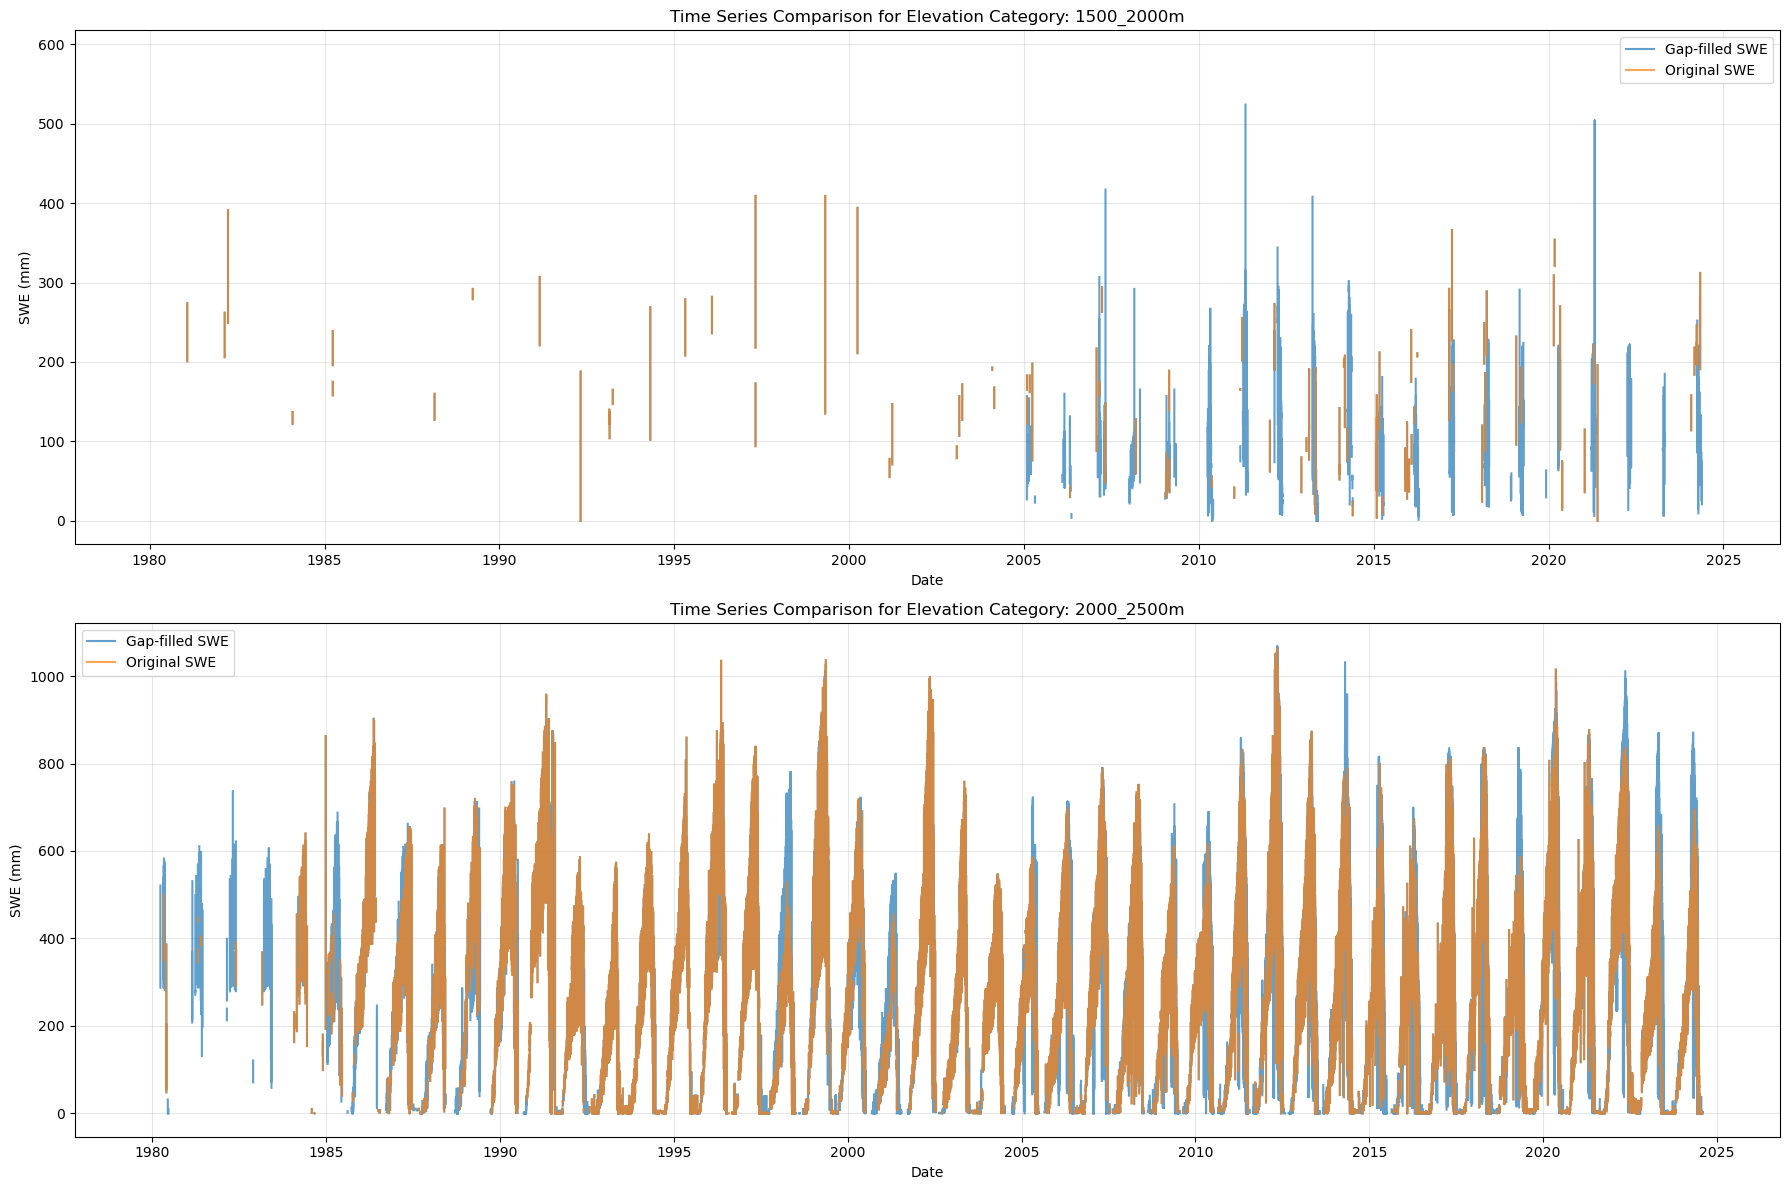

In [5]:
# Plot time series for each elevation category comparing Original_SWE and Gap_filled_SWE
elev_categories = [ '1500_2000m', '2000_2500m']

plt.figure(figsize=(18, 12))
for i, elev_cat in enumerate(elev_categories, 1):
    plt.subplot(len(elev_categories), 1, i)

    # Filter data for the current elevation category and sort by time
    df_cat = combined_canswe.loc[combined_canswe['Elevation_Category'] == elev_cat].sort_values('time')

    # Plot Gap-filled SWE (x and y have matching lengths)
    plt.plot(
        df_cat['time'],
        df_cat['Gap_Filled_CanSWE'],
        label='Gap-filled SWE',
        color='tab:blue',
        alpha=0.7
    )

    # Plot Original SWE (x and y have matching lengths)
    plt.plot(
        df_cat['time'],
        df_cat['Original_CanSWE'],
        label='Original SWE',
        color='tab:orange',
        alpha=0.7
    )

    plt.title(f'Time Series Comparison for Elevation Category: {elev_cat}')
    plt.xlabel('Date')
    plt.ylabel('SWE (mm)')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Select data for the season
1. Winter months November to April data are selected

In [6]:
# Enforce allowed seasonal-year range inside the selector
def select_seasonal_data(ts, start_month, end_month, min_year, max_year):
    month = ts.month
    year = ts.year
    if month >= start_month:
        seasonal_year = year
    elif month <= end_month:
        seasonal_year = year - 1
    else:
        return np.nan
    return seasonal_year if (min_year <= seasonal_year <= max_year) else np.nan

# For CanSWE data
combined_canswe['Seasonal_Year'] = combined_canswe['time'].apply(
    lambda ts: select_seasonal_data(ts, start_month=10, end_month=5, min_year=1980, max_year=2023)
)

# Remove rows where Seasonal_Year is NaN (outside the allowed data range)
combined_canswe = combined_canswe.dropna(subset=['Seasonal_Year'])

# Save the final combined CanSWE data with Seasonal_Year column
#combined_canswe.to_csv(output_dir / 'bow_combined_canswe_gapfilled_data_with_seasonal_year.csv', index=False)

# Display final combined CanSWE data
display(combined_canswe)

,station_id,time,lat,lon,elevation,Original_CanSWE,Gap_Filled_CanSWE,Elevation_Category,Seasonal_Year
19267,ALE-05BA811,1980-10-01,51.700001,-116.466667,2080.0,NaN,NaN,2000_2500m,1980.0
19268,ALE-05BA811,1980-10-02,51.700001,-116.466667,2080.0,NaN,NaN,2000_2500m,1980.0
19269,ALE-05BA811,1980-10-03,51.700001,-116.466667,2080.0,NaN,NaN,2000_2500m,1980.0
19270,ALE-05BA811,1980-10-04,51.700001,-116.466667,2080.0,NaN,NaN,2000_2500m,1980.0
19271,ALE-05BA811,1980-10-05,51.700001,-116.466667,2080.0,NaN,NaN,2000_2500m,1980.0
...,...,...,...,...,...,...,...,...,...
2751540,ALE-05CA805P,2024-05-27,51.542156,-116.060966,2120.0,181.0,181.0,2000_2500m,2023.0
2751541,ALE-05CA805P,2024-05-28,51.542156,-116.060966,2120.0,159.0,159.0,2000_2500m,2023.0
2751542,ALE-05CA805P,2024-05-29,51.542156,-116.060966,2120.0,144.0,144.0,2000_2500m,2023.0
2751543,ALE-05CA805P,2024-05-30,51.542156,-116.060966,2120.0,138.0,138.0,2000_2500m,2023.0


In [7]:
# For CaSR data
casr_data['Seasonal_Year'] = casr_data['time'].apply(
    lambda ts: select_seasonal_data(ts, start_month=10, end_month=5, min_year=1980, max_year=2023)
)
# Remove rows where Seasonal_Year is NaN (outside the allowed data range)
casr_data = casr_data.dropna(subset=['Seasonal_Year'])
#save the final CaSR data with Seasonal_Year column
#casr_data.to_csv(output_dir / 'bow_casr_data_with_seasonal_year.csv', index=False)

# Display final CaSR data
display(casr_data)

,Grid_id,time,lon,lat,SWE,Precipitation,Mean_Temp,Max_Temp,Humidity,Flux,Surface_Pressure,Vwind,Elevation_Category,Seasonal_Year
0,1,1980-10-10,-116.1380,51.3346,0.878418,0.009879,-3.783902,6.402542,0.002236,127.042317,792.259058,0.311295,2000_2500m,1980.0
2,2,1983-10-12,-116.1875,51.4191,6.875000,0.023846,-3.537311,8.740372,0.002839,139.681642,793.773767,-0.336093,2000_2500m,1983.0
3,2,1980-12-11,-116.1875,51.4191,118.125000,4.578907,-7.179487,-2.481613,0.002436,19.707682,778.646749,0.921281,2000_2500m,1980.0
5,2,1982-10-29,-116.1875,51.4191,23.125000,1.777088,-8.325263,-1.888809,0.002016,107.054688,774.911829,-0.176696,2000_2500m,1982.0
6,2,1982-01-18,-116.1875,51.4191,145.000000,1.890419,-16.744781,-13.240707,0.001073,46.103516,765.437045,-0.148752,2000_2500m,1981.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4224297,257,2024-02-22,-111.6202,50.0960,6.250000,0.011239,-1.576073,6.687103,0.003107,108.449219,927.793413,0.055882,500_1000m,2023.0
4224298,257,2024-03-19,-111.6202,50.0960,0.000488,0.000257,4.113504,15.721069,0.003839,142.319010,931.615300,-3.568600,500_1000m,2023.0
4224301,257,2024-01-06,-111.6202,50.0960,0.625000,0.135581,-2.378316,3.416687,0.002423,49.097006,918.650769,2.518928,500_1000m,2023.0
4224302,257,2024-05-17,-111.6202,50.0960,0.000000,6.328213,10.449311,22.100280,0.006565,158.558594,913.620910,-6.381619,500_1000m,2023.0


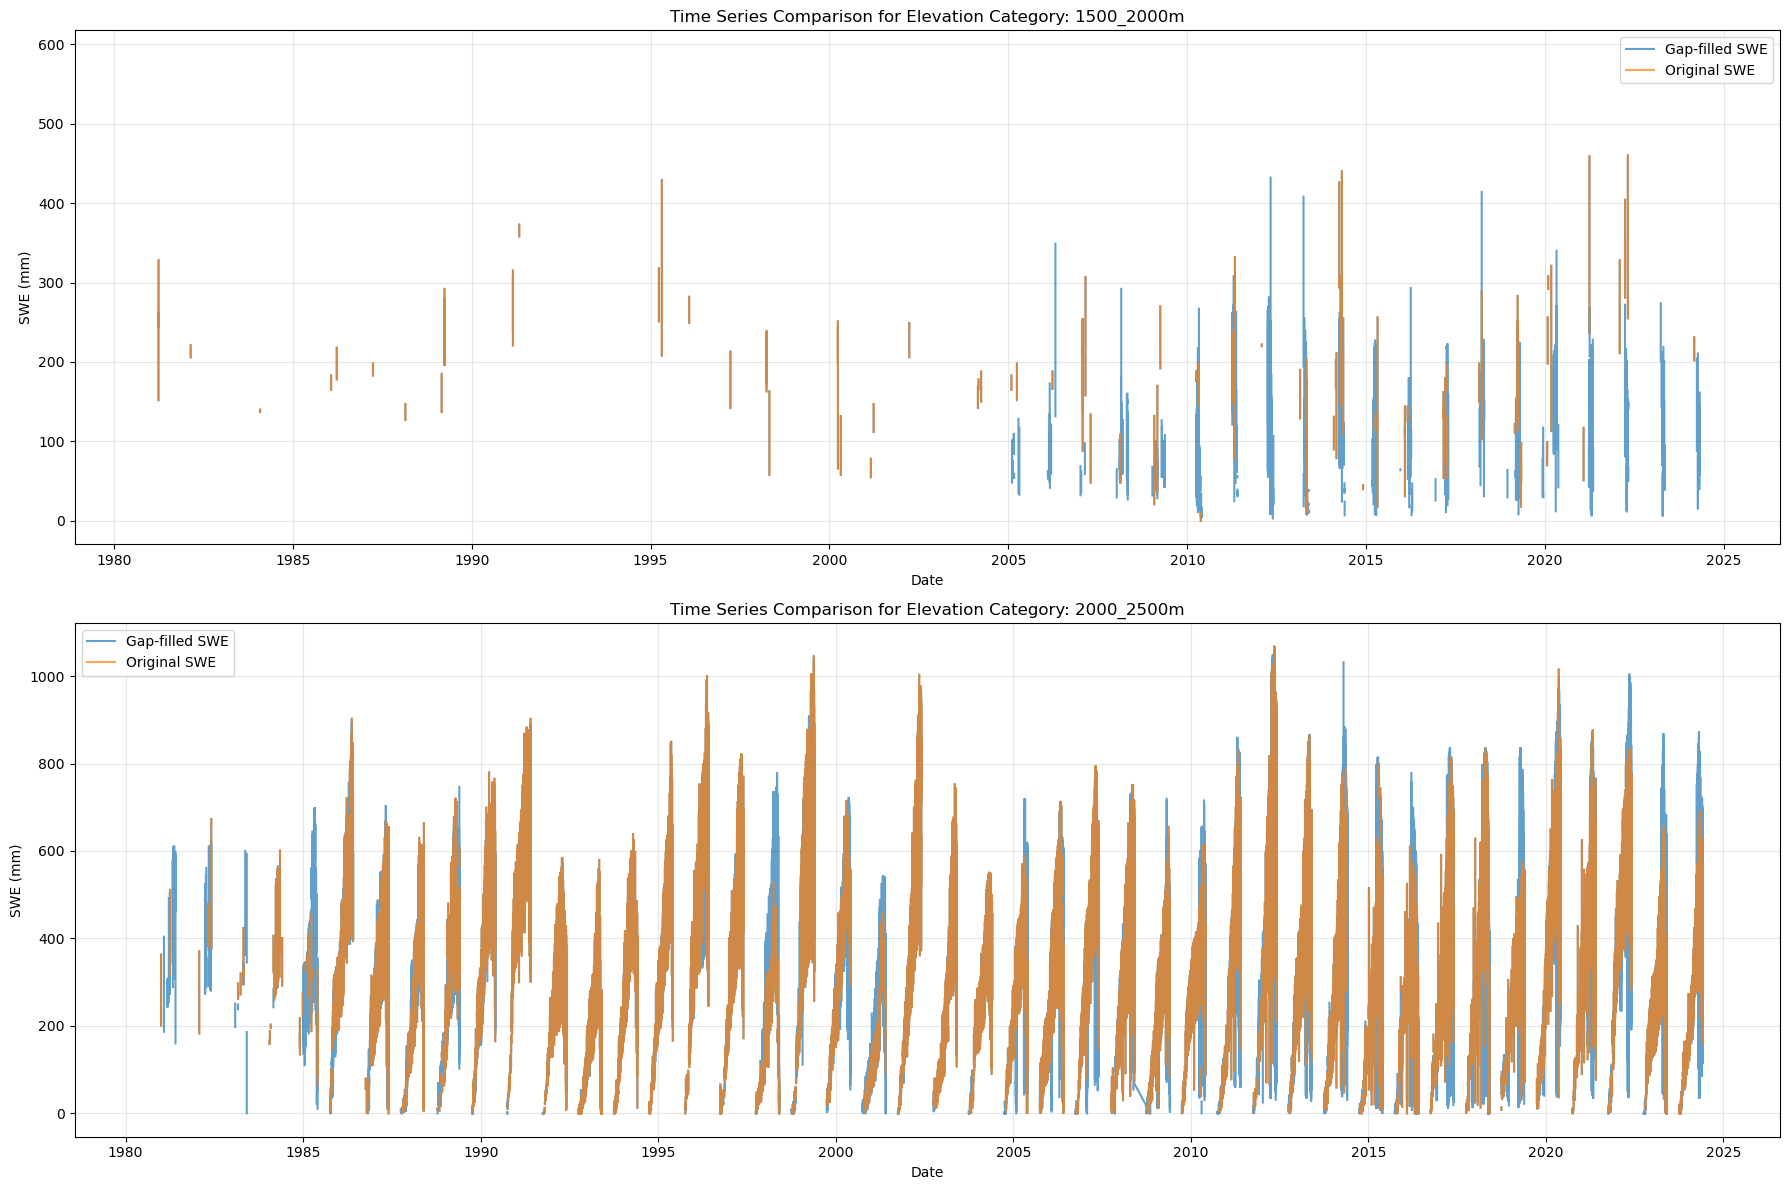

In [8]:
# Plot time series for each elevation category comparing Original_SWE and Gap_filled_SWE
elev_categories = [ '1500_2000m', '2000_2500m']

plt.figure(figsize=(18, 12))
for i, elev_cat in enumerate(elev_categories, 1):
    plt.subplot(len(elev_categories), 1, i)

    # Filter data for the current elevation category and sort by time
    df_cat = combined_canswe.loc[combined_canswe['Elevation_Category'] == elev_cat].sort_values('time')

    # Plot Gap-filled SWE (x and y have matching lengths)
    plt.plot(
        df_cat['time'],
        df_cat['Gap_Filled_CanSWE'],
        label='Gap-filled SWE',
        color='tab:blue',
        alpha=0.7
    )

    # Plot Original SWE (x and y have matching lengths)
    plt.plot(
        df_cat['time'],
        df_cat['Original_CanSWE'],
        label='Original SWE',
        color='tab:orange',
        alpha=0.7
    )

    plt.title(f'Time Series Comparison for Elevation Category: {elev_cat}')
    plt.xlabel('Date')
    plt.ylabel('SWE (mm)')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate SWEI

Functions

In [9]:

def extract_grid_metadata(df: pd.DataFrame) -> pd.DataFrame:
    """
    Extract per-Grid static metadata.
    """
    return (
        df[["Grid_id", "lon", "lat", "Elevation_Category"]]
        .drop_duplicates("Grid_id")
        .set_index("Grid_id")
    )


def daily_to_monthly_swe(df: pd.DataFrame) -> pd.DataFrame:
    """
    Daily SWE → monthly integrated SWE.
    Seasonal_Year is recomputed from time.
    """
    out = df.copy()
    out["time"] = pd.to_datetime(out["time"])

    monthly = (
        out
        .groupby(
            ["Grid_id", pd.Grouper(key="time", freq="MS")],
            as_index=False
        )
        .agg(
            SWE_monthly=("SWE", "sum")
        )
    )

    # Recompute Seasonal_Year (e.g., Oct–Sep water year)
    monthly["Seasonal_Year"] = np.where(
        monthly["time"].dt.month >= 10,
        monthly["time"].dt.year,
        monthly["time"].dt.year - 1
    )

    return monthly



def rolling_integrated_swe_by_season(
    monthly_df: pd.DataFrame,
    window_months: int
) -> pd.DataFrame:
    """
    Compute rolling k‑month integrated SWE within each Seasonal_Year.

    • Rolling windows do NOT cross Seasonal_Year boundaries.
    • First (k‑1) months of each season are dropped.
    • Works for any window (3, 6, 8, …).
    """

    out = monthly_df.copy()
    out = out.sort_values(["Grid_id", "Seasonal_Year", "time"])

    out[f"SWE_{window_months}mo"] = (
        out
        .groupby(["Grid_id", "Seasonal_Year"])["SWE_monthly"]
        .rolling(window=window_months, min_periods=window_months)
        .sum()
        .reset_index(level=[0, 1], drop=True)
    )

    return out.dropna(subset=[f"SWE_{window_months}mo"])



def gringorten_probabilities(x: np.ndarray) -> np.ndarray:
    """
    Gringorten plotting position with:
    - NaN handling
    - average ranks for ties
    - probability clipping
    """
    x = np.asarray(x, float)
    out = np.full_like(x, np.nan)

    mask = ~np.isnan(x)
    xv = x[mask]

    if xv.size == 0:
        return out

    # ranks with average ties
    order = np.argsort(xv, kind="mergesort")
    ranks = np.empty_like(order, dtype=float)
    ranks[order] = np.arange(1, len(xv) + 1)

    uvals, inv, cnt = np.unique(xv, return_inverse=True, return_counts=True)
    for i, c in enumerate(cnt):
        if c > 1:
            idx = np.where(inv == i)[0]
            ranks[idx] = ranks[idx].mean()

    N = float(len(xv))
    p = (ranks - 0.44) / (N + 0.12)
    p = np.clip(p, 1e-12, 1 - 1e-12)

    out[mask] = p
    return out


def compute_swei_for_grid(
    df: pd.DataFrame,
    swe_col: str,
    nonzero_frac_threshold: float = 0.75
) -> pd.DataFrame:
    """
    Compute SWEI for ONE Grid_id using calendar-month standardization.
    """
    out = df.copy()
    out["month"] = out["time"].dt.month

    pvals = np.full(len(out), np.nan)
    zvals = np.full(len(out), np.nan)

    for m in range(1, 13):
        idx = out["month"] == m
        vals = out.loc[idx, swe_col]

        valid = vals.notna()
        if valid.sum() == 0:
            continue

        frac_nonzero = (vals[valid] > 0).mean()
        if frac_nonzero < nonzero_frac_threshold:
            continue  # Near-normal (NN)

        p = gringorten_probabilities(vals.values)
        z = norm.ppf(p)

        pvals[idx] = p
        zvals[idx] = z

    out["Gringorten_p"] = pvals
    out["SWEI"] = zvals
    return out



def compute_swei(
    df: pd.DataFrame,
    window_months: int = 3
) -> pd.DataFrame:
    """
    End‑to‑end SWEI calculation with metadata preservation.
    """

    # 0. Extract static grid metadata
    grid_meta = extract_grid_metadata(df)

    # 1. Daily → monthly SWE
    monthly = daily_to_monthly_swe(df)

    # 2. Rolling integration
    integ = rolling_integrated_swe_by_season(monthly, window_months)

    # 3. Compute SWEI per grid
    swei = (
        integ
        .groupby("Grid_id", group_keys=False)
        .apply(
            lambda g: compute_swei_for_grid(
                g,
                swe_col=f"SWE_{window_months}mo"
            )
        )
    )

    # 4. Reattach static metadata
    swei = swei.join(grid_meta, on="Grid_id")

    return swei


def plot_seasonal_sswei_maps(
    swei_df,
    basin_gdf,
    config,
    window_label="3-month",
    swei_col="Avg_SWEI_3mo",
    start_year=1980,
    end_year=2024,
    month_order=(10, 11, 12, 1, 2, 3, 4, 5),
    month_names=None,
    classify_func=None,
    severity_colors=None,
    nrows=2,
    ncols=3,
    figsize=(20, 10),
    dpi=300
):
    """
    Plot seasonal SSWEI maps for each Seasonal_Year.

    Parameters
    ----------
    swei_df : pandas.DataFrame
        DataFrame containing SSWEI values with columns:
        ['Seasonal_Year', 'month', 'Elevation_Category', swei_col].
    basin_gdf : geopandas.GeoDataFrame
        Basin polygons with elevation categories column 'elev_class'.
    config : dict
        Configuration dictionary containing output directory path:
        config['SWEI_plots'].
    window_label : str
        Text label for SWEI window (e.g., '3-month', '6-month', '8-month').
    swei_col : str
        Column name containing SSWEI values.
    start_year, end_year : int
        Seasonal_Year range to plot (end_year is exclusive).
    month_order : iterable
        Ordered months for snow season (default Oct–May).
    month_names : dict
        Mapping of month number → month name.
    classify_func : callable
        Function that maps SSWEI → drought class.
    severity_colors : dict
        Mapping of drought class → color.
    nrows, ncols : int
        Subplot grid dimensions.
    figsize : tuple
        Figure size.
    dpi : int
        Output resolution.
    """

    if month_names is None:
        month_names = {
            1: "January", 2: "February", 3: "March", 4: "April",
            5: "May", 10: "October", 11: "November", 12: "December"
        }

    if classify_func is None or severity_colors is None:
        raise ValueError("Both classify_func and severity_colors must be provided.")

    for season_year in range(start_year, end_year):

        # Subset data for this season
        swei_year = swei_df[swei_df["Seasonal_Year"] == season_year]
        if swei_year.empty:
            continue

        # Determine months present and in correct order
        available_months = swei_year["month"].unique().tolist()
        months_year = [m for m in month_order if m in available_months]
        n_months = len(months_year)

        # Create subplot grid
        fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
        axes = axes.flatten()

        for idx, month in enumerate(months_year):
            ax = axes[idx]

            # Subset month data
            month_data = swei_year[swei_year["month"] == month]

            # Prepare elevation-band SSWEI table
            sswei_long = (
                month_data[["Elevation_Category", swei_col]]
                .rename(columns={swei_col: "SSWEI"})
            )

            # Merge with basin geometry
            basin_plot = basin_gdf.merge(
                sswei_long,
                left_on="elev_class",
                right_on="Elevation_Category",
                how="left"
            )

            # Classify SSWEI and assign colors
            basin_plot["Drought_Classification"] = (
                basin_plot["SSWEI"].apply(classify_func)
            )
            basin_plot["color"] = (
                basin_plot["Drought_Classification"]
                .map(severity_colors)
                .fillna("#dddddd")
            )

            # Plot
            basin_plot.plot(
                ax=ax,
                color=basin_plot["color"],
                edgecolor="black",
                linewidth=0.5
            )

            # Display year logic
            display_year = season_year if month >= 10 else season_year + 1

            ax.set_title(
                f"{month_names.get(month, str(month))} {display_year}",
                fontsize=12,
                fontweight="bold"
            )
            ax.axis("off")

        # Hide unused axes
        for j in range(n_months, len(axes)):
            axes[j].set_visible(False)

        # Figure title and legend
        fig.suptitle(
            f"{window_label} SSWEI Distribution across Bow River Basin "
            f"(Season {season_year})",
            fontsize=16,
            fontweight="bold",
            y=0.98
        )

        legend_handles = [
            mpatches.Patch(color=c, label=l)
            for l, c in severity_colors.items()
        ]
        fig.legend(
            handles=legend_handles,
            bbox_to_anchor=(1.05, 1),
            loc="upper left",
            title="Drought Severity"
        )

        plt.tight_layout()

        # Save output
        out_file = (
            config["SWEI_plots"]
            / f"SSWEI_bow_basin_monthly_{window_label.replace(' ', '_')}_{season_year}.png"
        )
        fig.savefig(out_file, dpi=dpi, bbox_inches="tight")
        plt.close(fig)



1-Month SWEI

In [10]:
# 1-month SWEI
swei_1mo = compute_swei(casr_data, window_months=1)
swei_1mo_output_dir = config['SWEI_output_dir'] 
swei_1mo_output_dir.mkdir(parents=True, exist_ok=True)
swei_1mo.to_csv(swei_1mo_output_dir / 'bow_casr_swei_1mo.csv', index=False)

display(swei_1mo.head())

,Grid_id,time,SWE_monthly,Seasonal_Year,SWE_1mo,month,Gringorten_p,SWEI,lon,lat,Elevation_Category
0,1,1980-10-01,206.20874,1980,206.20874,10,0.262013,-0.637153,-116.138,51.3346,2000_2500m
1,1,1980-11-01,1297.43750,1980,1297.43750,11,0.511333,0.028411,-116.138,51.3346,2000_2500m
2,1,1980-12-01,3418.97217,1980,3418.97217,12,0.873980,1.145409,-116.138,51.3346,2000_2500m
3,1,1981-01-01,4229.06250,1980,4229.06250,1,0.647325,0.378110,-116.138,51.3346,2000_2500m
4,1,1981-02-01,4490.93750,1980,4490.93750,2,0.443336,-0.142516,-116.138,51.3346,2000_2500m


In [11]:
# avaerage SWEI over the Elevation categories, month and seasonal year
swei_1mo_avg = (
    swei_1mo
    .groupby(
        ['Elevation_Category', 'Seasonal_Year', 'month'],
        as_index=False
    )
    .agg(
        Avg_SWEI_1mo=('SWEI', 'mean')
    )
)

display(swei_1mo_avg)

,Elevation_Category,Seasonal_Year,month,Avg_SWEI_1mo
0,1000_1500m,1980,1,-1.573456
1,1000_1500m,1980,2,-0.754661
2,1000_1500m,1980,3,-1.294272
3,1000_1500m,1980,4,-0.979583
4,1000_1500m,1980,5,1.227319
...,...,...,...,...
1403,500_1000m,2023,4,0.266537
1404,500_1000m,2023,5,0.536958
1405,500_1000m,2023,10,1.030850
1406,500_1000m,2023,11,-0.990671


In [12]:
# extract 2023 seasonal year data
swei_1mo_2023 = swei_1mo_avg[swei_1mo_avg['Seasonal_Year'] == 2023]
display(swei_1mo_2023)

,Elevation_Category,Seasonal_Year,month,Avg_SWEI_1mo
344,1000_1500m,2023,1,0.237792
345,1000_1500m,2023,2,0.116545
346,1000_1500m,2023,3,0.718382
347,1000_1500m,2023,4,0.462958
348,1000_1500m,2023,5,0.676048
349,1000_1500m,2023,10,0.968895
350,1000_1500m,2023,11,-0.763666
351,1000_1500m,2023,12,-0.442060
696,1500_2000m,2023,1,0.837143
697,1500_2000m,2023,2,1.255874


In [ ]:
# Plot monthly SSWEI on bow basin subplots

# Desired month order: October (10) to May (5)
month_order = [10, 11, 12, 1, 2, 3, 4, 5]
# Keep only months that actually exist in the data, in the desired order
available_months = swei_1mo_2023['month'].unique().tolist()
months = [m for m in month_order if m in available_months]

n_months = len(months)

# Create subplot grid (2 rows x 4 columns for up to 8 months)
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

# Define a color map for drought severity (keys match classify_sswei output)
severity_colors_SWEI = {
    'Exceptional Drought': '#800026',
    'Extreme Drought': '#BD0026',
    'Severe Drought': '#E31A1C',
    'Moderate Dry': '#FD8D3C',
    'Abnaormally Dry': '#FED976',
    'Near Normal': '#FFFFCC',
    'Abnormally Wet': '#C7E9B4',
    'Moderate Wet': '#7FCDBB',
    'Severe Wet': '#41B6C4',
    'Extreme Wet': '#225EA8',
    'Extremely Wet': '#0C2C84',
    'No Data': '#dddddd'
}

# Create a classification function for SSWEI values
# (same thresholds as before)
def classify_sswei(value):
    if pd.isna(value):
        return 'No Data'
    elif value <= -2.0:
        return 'Exceptional Drought'
    elif value < -1.6:
        return 'Extreme Drought'
    elif value < -1.3:
        return 'Severe Drought'
    elif value < -0.8:
        return 'Moderate Dry'
    elif value < -0.5:
        return 'Abnaormally Dry'
    elif value < 0.5:
        return 'Near Normal'
    elif value < 0.8:
        return 'Abnormally Wet'
    elif value < 1.3:
        return 'Moderate Wet'
    elif value < 1.6:
        return 'Severe Wet'
    elif value < 2.0:
        return 'Extreme Wet'
    else:
        return 'Extremely Wet'

# Initialize color column (will be updated per month in the loop)
bow_basin['color'] = '#dddddd'

# Month names for titles
month_names = {10: 'October', 11: 'November', 12: 'December',
               1: 'January', 2: 'February', 3: 'March',
               4: 'April', 5: 'May'}

# Plot each month
for season_year in range(1980, 2024):
    # SSWEI data for this season
    swei_year = swei_1mo_avg[swei_1mo_avg['Seasonal_Year'] == season_year]

    # Months available for this season, in desired order
    available_months = swei_year['month'].unique().tolist()
    months_year = [m for m in month_order if m in available_months]
    n_months_year = len(months_year)

    # Create subplot grid (2 rows x 4 columns for up to 8 months)
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.flatten()

    for idx, month in enumerate(months_year):
        ax = axes[idx]

        # Subset SSWEI for this month and season
        month_data = swei_year[swei_year['month'] == month].copy()

        # One row per elevation band; just select and rename
        month_data_long = month_data[['Elevation_Category', 'Avg_SWEI_1mo']].copy()
        month_data_long = month_data_long.rename(columns={'Avg_SWEI_1mo': 'SSWEI'})

        # Merge SSWEI values with basin geometry using elevation categories
        basin_plot = bow_basin.merge(
            month_data_long[['Elevation_Category', 'SSWEI']],
            left_on='elev_class',
            right_on='Elevation_Category',
            how='left'
        )

        # Classify SSWEI values and assign colors
        basin_plot['Drought_Classification'] = basin_plot['SSWEI'].apply(classify_sswei)
        basin_plot['color'] = basin_plot['Drought_Classification'].map(severity_colors_SWEI).fillna('#dddddd')

        # Plot the basin with SSWEI values
        basin_plot.plot(ax=ax, color=basin_plot['color'], edgecolor='black', linewidth=0.5)

        # Calendar year for the given month in this snow season
        display_year = season_year if month >= 10 else season_year + 1
        ax.set_title(f"{month_names.get(month, str(month))} {display_year}",
                     fontsize=12, fontweight='bold')
        ax.axis('off')

    # Hide any unused subplots (if fewer than 8 months)
    for j in range(n_months_year, len(axes)):
        axes[j].set_visible(False)

    plt.suptitle(f'Monthly SSWEI Distribution across Bow River Basin (Season {season_year})',
                 fontsize=16, fontweight='bold', y=0.98)

    plt.legend(handles=[mpatches.Patch(color=color, label=label)
                        for label, color in severity_colors_SWEI.items()],
               bbox_to_anchor=(1.05, 1), loc='upper left',
               borderaxespad=0., title='Drought Severity')
    plt.tight_layout()

    # Save figure for this season
    #out_file_map = config['SWEI_plots'] / f'SSWEI_bow_basin_monthly_{season_year}.png'
    #fig.savefig(out_file_map, dpi=300, bbox_inches='tight')
   # plt.show()

3 - Month SWEI

In [14]:
# 3-month SWEI
swei_3mo = compute_swei(casr_data, window_months=3)
swei_3mo_output_dir = config['SWEI_output_dir'] 
swei_3mo_output_dir.mkdir(parents=True, exist_ok=True)
swei_3mo.to_csv(swei_3mo_output_dir / 'bow_casr_swei_3mo.csv', index=False)

display(swei_3mo)

,Grid_id,time,SWE_monthly,Seasonal_Year,SWE_3mo,month,Gringorten_p,SWEI,lon,lat,Elevation_Category
2,1,1980-12-01,3418.972170,1980,4922.618410,12,0.737987,0.637153,-116.1380,51.3346,2000_2500m
3,1,1981-01-01,4229.062500,1980,8945.472170,1,0.715322,0.569000,-116.1380,51.3346,2000_2500m
4,1,1981-02-01,4490.937500,1980,12138.972170,2,0.647325,0.378110,-116.1380,51.3346,2000_2500m
5,1,1981-03-01,5416.625000,1980,14136.625000,3,0.466002,-0.085324,-116.1380,51.3346,2000_2500m
6,1,1981-04-01,6174.931640,1980,16082.494140,4,0.443336,-0.142516,-116.1380,51.3346,2000_2500m
...,...,...,...,...,...,...,...,...,...,...,...
90459,257,2024-01-01,188.628906,2023,215.202453,1,0.171351,-0.948841,-111.6202,50.0960,500_1000m
90460,257,2024-02-01,147.339844,2023,351.277984,2,0.375340,-0.317743,-111.6202,50.0960,500_1000m
90461,257,2024-03-01,228.636963,2023,564.605712,3,0.579329,0.200177,-111.6202,50.0960,500_1000m
90462,257,2024-04-01,33.114258,2023,409.091064,4,0.715322,0.569000,-111.6202,50.0960,500_1000m


In [15]:
# avaerage SWEI over the Elevation categories, month and seasonal year
swei_3mo_avg = (
    swei_3mo
    .groupby(
        ['Elevation_Category', 'Seasonal_Year','month'],
        as_index=False
    )
    .agg(
        Avg_SWEI_3mo=('SWEI', 'mean')
    )
)

display(swei_3mo_avg.head(15))

,Elevation_Category,Seasonal_Year,month,Avg_SWEI_3mo
0,1000_1500m,1980,1,-0.002038
1,1000_1500m,1980,2,-0.254388
2,1000_1500m,1980,3,-2.022103
3,1000_1500m,1980,4,-1.538498
4,1000_1500m,1980,5,-1.075890
5,1000_1500m,1980,12,0.403853
6,1000_1500m,1981,1,-0.255568
7,1000_1500m,1981,2,0.421963
8,1000_1500m,1981,3,0.707197
9,1000_1500m,1981,4,0.858082


In [ ]:
# Plot each month
for season_year in range(1980, 2024):
    # SSWEI data for this season
    swei_year = swei_3mo_avg[swei_3mo_avg['Seasonal_Year'] == season_year]

    # Months available for this season, in desired order
    available_months = swei_year['month'].unique().tolist()
    months_year = [m for m in month_order if m in available_months]
    n_months_year = len(months_year)

    # Create subplot grid (2 rows x 3 columns for up to 6 months)
    fig, axes = plt.subplots(2, 3, figsize=(20, 10))
    axes = axes.flatten()

    for idx, month in enumerate(months_year):
        ax = axes[idx]

        # Subset SSWEI for this month and season
        month_data = swei_year[swei_year['month'] == month].copy()

        # One row per elevation band; just select and rename
        month_data_long = month_data[['Elevation_Category', 'Avg_SWEI_3mo']].copy()
        month_data_long = month_data_long.rename(columns={'Avg_SWEI_3mo': 'SSWEI'})

        # Merge SSWEI values with basin geometry using elevation categories
        basin_plot = bow_basin.merge(
            month_data_long[['Elevation_Category', 'SSWEI']],
            left_on='elev_class',
            right_on='Elevation_Category',
            how='left'
        )

        # Classify SSWEI values and assign colors
        basin_plot['Drought_Classification'] = basin_plot['SSWEI'].apply(classify_sswei)
        basin_plot['color'] = basin_plot['Drought_Classification'].map(severity_colors_SWEI).fillna('#dddddd')

        # Plot the basin with SSWEI values
        basin_plot.plot(ax=ax, color=basin_plot['color'], edgecolor='black', linewidth=0.5)

        # Calendar year for the given month in this snow season
        display_year = season_year if month >= 10 else season_year + 1
        ax.set_title(f"{month_names.get(month, str(month))} {display_year}",
                     fontsize=12, fontweight='bold')
        ax.axis('off')

    # Hide any unused subplots (if fewer than 8 months)
    for j in range(n_months_year, len(axes)):
        axes[j].set_visible(False)

    plt.suptitle(f'3-month SSWEI Distribution across Bow River Basin (Season {season_year})',
                 fontsize=16, fontweight='bold', y=0.98)

    plt.legend(handles=[mpatches.Patch(color=color, label=label)
                        for label, color in severity_colors_SWEI.items()],
               bbox_to_anchor=(1.05, 1), loc='upper left',
               borderaxespad=0., title='Drought Severity')
    plt.tight_layout()

    # Save figure for this season
    #out_file_map = config['SWEI_plots'] / f'SSWEI_bow_basin_monthly_{season_year}.png'
    #fig.savefig(out_file_map, dpi=300, bbox_inches='tight')
   # plt.show()

Seasonal SWEI - 8 months

In [17]:
# 8-month SWEI
swei_8mo = compute_swei(casr_data, window_months=8)
swei_8mo_output_dir = config['SWEI_output_dir'] 
swei_8mo_output_dir.mkdir(parents=True, exist_ok=True)
swei_8mo.to_csv(swei_8mo_output_dir / 'bow_casr_swei_8mo.csv', index=False)

display(swei_8mo)

,Grid_id,time,SWE_monthly,Seasonal_Year,SWE_8mo,month,Gringorten_p,SWEI,lon,lat,Elevation_Category
7,1,1981-05-01,5072.800764,1980,30306.975814,5,0.556664,0.142516,-116.1380,51.3346,2000_2500m
15,1,1982-05-01,7276.954120,1981,34493.079364,5,0.737987,0.637153,-116.1380,51.3346,2000_2500m
23,1,1983-05-01,5607.820307,1982,34208.649527,5,0.692656,0.503394,-116.1380,51.3346,2000_2500m
31,1,1984-05-01,5777.537110,1983,28006.298830,5,0.420671,-0.200177,-116.1380,51.3346,2000_2500m
39,1,1985-05-01,4583.076164,1984,26935.667961,5,0.352675,-0.378110,-116.1380,51.3346,2000_2500m
...,...,...,...,...,...,...,...,...,...,...,...
90431,257,2020-05-01,0.000000,2019,584.591553,5,0.284678,-0.569000,-111.6202,50.0960,500_1000m
90439,257,2021-05-01,11.372070,2020,579.107177,5,0.239347,-0.708404,-111.6202,50.0960,500_1000m
90447,257,2022-05-01,0.000000,2021,283.044342,5,0.012693,-2.235488,-111.6202,50.0960,500_1000m
90455,257,2023-05-01,0.000000,2022,743.058776,5,0.466002,-0.085324,-111.6202,50.0960,500_1000m


In [18]:
# avaerage SWEI over the Elevation categories, month and seasonal year
swei_8mo_avg = (
    swei_8mo
    .groupby(
        ['Elevation_Category', 'Seasonal_Year','month'],
        as_index=False
    )
    .agg(
        Avg_SWEI_8mo=('SWEI', 'mean')
    )
)

display(swei_8mo_avg.head(15))

,Elevation_Category,Seasonal_Year,month,Avg_SWEI_8mo
0,1000_1500m,1980,5,-0.778473
1,1000_1500m,1981,5,0.320094
2,1000_1500m,1982,5,-0.942805
3,1000_1500m,1983,5,-0.356098
4,1000_1500m,1984,5,-0.147442
5,1000_1500m,1985,5,0.314323
6,1000_1500m,1986,5,-0.474813
7,1000_1500m,1987,5,-1.338402
8,1000_1500m,1988,5,0.898300
9,1000_1500m,1989,5,0.113604


In [19]:
#print snow drought years for each elevation category
for elev_cat in swei_8mo_avg['Elevation_Category'].unique():
    elev_data = swei_8mo_avg[swei_8mo_avg['Elevation_Category'] == elev_cat]
    drought_years = elev_data[elev_data['Avg_SWEI_8mo'] <= -0.5]['Seasonal_Year'].unique()
    print(f"Elevation Category: {elev_cat}, Drought Years (Avg SWEI <= -0.5): {drought_years.tolist()}")

Elevation Category: 1000_1500m, Drought Years (Avg SWEI <= -0.5): [1980, 1982, 1987, 1991, 1993, 1994, 1998, 2000, 2004, 2005, 2007, 2011, 2015]
Elevation Category: 1500_2000m, Drought Years (Avg SWEI <= -0.5): [1980, 1991, 1993, 1994, 1998, 2000, 2002, 2004, 2005, 2006, 2007, 2011, 2015]
Elevation Category: 2000_2500m, Drought Years (Avg SWEI <= -0.5): [1987, 1996, 1997, 1998, 2000, 2002, 2004, 2005, 2009, 2011, 2015]
Elevation Category: 500_1000m, Drought Years (Avg SWEI <= -0.5): [1994, 1997, 1998, 2000, 2004, 2005, 2006, 2011, 2015, 2016, 2018, 2021, 2023]


In [ ]:
# Plot each month
for season_year in range(1980, 2024):
    # SSWEI data for this season
    swei_year = swei_8mo_avg[swei_8mo_avg['Seasonal_Year'] == season_year]

    # Months available for this season, in desired order
    available_months = swei_year['month'].unique().tolist()
    months_year = [m for m in month_order if m in available_months]
    n_months_year = len(months_year)

    # Create subplot grid (1 rows x 1 columns for up to 6 months)
    fig, axes = plt.subplots(1, 1, figsize=(20, 10))
    axes = np.atleast_1d(axes).ravel()

    for idx, month in enumerate(months_year):
        ax = axes[idx]

        # Subset SSWEI for this month and season
        month_data = swei_year[swei_year['month'] == month].copy()

        # One row per elevation band; just select and rename
        month_data_long = month_data[['Elevation_Category', 'Avg_SWEI_8mo']].copy()
        month_data_long = month_data_long.rename(columns={'Avg_SWEI_8mo': 'SSWEI'})

        # Merge SSWEI values with basin geometry using elevation categories
        basin_plot = bow_basin.merge(
            month_data_long[['Elevation_Category', 'SSWEI']],
            left_on='elev_class',
            right_on='Elevation_Category',
            how='left'
        )

        # Classify SSWEI values and assign colors
        basin_plot['Drought_Classification'] = basin_plot['SSWEI'].apply(classify_sswei)
        basin_plot['color'] = basin_plot['Drought_Classification'].map(severity_colors_SWEI).fillna('#dddddd')

        # Plot the basin with SSWEI values
        basin_plot.plot(ax=ax, color=basin_plot['color'], edgecolor='black', linewidth=0.5)

        # Calendar year for the given month in this snow season
        #display_year = season_year if month >= 10 else season_year + 1
        #ax.set_title(f"{month_names.get(month, str(month))} {display_year}",
        #             fontsize=12, fontweight='bold')
        ax.axis('off')

    # Hide any unused subplots (if fewer than 8 months)
    for j in range(n_months_year, len(axes)):
        axes[j].set_visible(False)

    plt.suptitle(f'8-month SSWEI Distribution across Bow River Basin (Season {season_year})',
                 fontsize=16, fontweight='bold', y=0.98)

    plt.legend(handles=[mpatches.Patch(color=color, label=label)
                        for label, color in severity_colors_SWEI.items()],
               bbox_to_anchor=(1.05, 1), loc='upper left',
               borderaxespad=0., title='Drought Severity')
    plt.tight_layout()

    # Save figure for this season
    #out_file_map = config['SWEI_plots'] / f'SSWEI_bow_basin_8month_{season_year}.png'
    #fig.savefig(out_file_map, dpi=300, bbox_inches='tight')
   # plt.show()

# SPI Calculations

In [21]:
# load percipitation data and compute SPI 
precip_data = casr_data[['time', 'Grid_id','lon', 'lat', 'Precipitation', 'Elevation_Category']].copy()
precip_data['time'] = pd.to_datetime(precip_data['time'])
precip_data['month'] = precip_data['time'].dt.month
display(precip_data.head())

,time,Grid_id,lon,lat,Precipitation,Elevation_Category,month
0,1980-10-10,1,-116.1380,51.3346,0.009879,2000_2500m,10
2,1983-10-12,2,-116.1875,51.4191,0.023846,2000_2500m,10
3,1980-12-11,2,-116.1875,51.4191,4.578907,2000_2500m,12
5,1982-10-29,2,-116.1875,51.4191,1.777088,2000_2500m,10
6,1982-01-18,2,-116.1875,51.4191,1.890419,2000_2500m,1


Functions

In [22]:
def extract_grid_metadata(df: pd.DataFrame) -> pd.DataFrame:
    """
    Extract per-Grid static metadata.
    """
    return (
        df[["Grid_id", "lon", "lat", "Elevation_Category"]]
        .drop_duplicates("Grid_id")
        .set_index("Grid_id")
    )


def daily_to_monthly_precipitation(df: pd.DataFrame) -> pd.DataFrame:
    """
    Daily precipitation → monthly integrated precipitation.
    Seasonal_Year is recomputed from time.
    """
    out = df.copy()
    out["time"] = pd.to_datetime(out["time"])

    monthly = (
        out
        .groupby(
            ["Grid_id", pd.Grouper(key="time", freq="MS")],
            as_index=False
        )
        .agg(
            Precipitation_monthly=("Precipitation", "sum")
        )
    )

    # Recompute Seasonal_Year (e.g., Oct–Sep water year)
    monthly["Seasonal_Year"] = np.where(
        monthly["time"].dt.month >= 10,
        monthly["time"].dt.year,
        monthly["time"].dt.year - 1
    )

    return monthly



def rolling_integrated_precipitation_by_season(
    monthly_df: pd.DataFrame,
    window_months: int
) -> pd.DataFrame:
    """
    Compute rolling k‑month integrated precipitation within each Seasonal_Year.

    • Rolling windows do NOT cross Seasonal_Year boundaries.
    • First (k‑1) months of each season are dropped.
    • Works for any window (3, 6, 8, …).
    """

    out = monthly_df.copy()
    out = out.sort_values(["Grid_id", "Seasonal_Year", "time"])

    out[f"Precipitation_{window_months}mo"] = (
        out
        .groupby(["Grid_id", "Seasonal_Year"])["Precipitation_monthly"]
        .rolling(window=window_months, min_periods=window_months)
        .sum()
        .reset_index(level=[0, 1], drop=True)
    )

    return out.dropna(subset=[f"Precipitation_{window_months}mo"])


def calculate_spi(series: pd.Series, min_samples: int = 20) -> pd.Series:
    """
    Calculates SPI using a mixed Gamma distribution.
    """
    x = series.values

    # Probability of zero precipitation
    q = np.mean(x == 0)

    pos = x[x > 0]
    if len(pos) < min_samples:
        return pd.Series(np.nan, index=series.index)

    shape, loc, scale = gamma.fit(pos, floc=0)
    
    G = gamma.cdf(x, shape, loc=loc, scale=scale)
    H = q + (1 - q) * G

    H = np.clip(H, 1e-6, 1 - 1e-6)

    spi = norm.ppf(H)

    return pd.Series(spi, index=series.index)



def compute_spi_for_grids(
    precip_df: pd.DataFrame,
    precip_col: str
) -> pd.DataFrame:

    out = []

    for grid_id, gdf in precip_df.groupby("Grid_id"):
        gdf = gdf.sort_values("time")

        for month in range(1, 13):
            mask = gdf["time"].dt.month == month
            spi_series = calculate_spi(gdf.loc[mask, precip_col])

            gdf.loc[mask, "SPI"] = spi_series

        gdf["Grid_id"] = grid_id
        out.append(gdf)

    return pd.concat(out).sort_values(["Grid_id", "time"])


def spi_pipeline(
    daily_df: pd.DataFrame,
    window_months: int
) -> pd.DataFrame:

    # 1. Metadata
    grid_meta = extract_grid_metadata(daily_df)

    # 2. Daily → Monthly
    monthly = daily_to_monthly_precipitation(daily_df)

    # 3. Rolling integrated precipitation
    rolled = rolling_integrated_precipitation_by_season(
        monthly,
        window_months=window_months
    )

    precip_col = f"Precipitation_{window_months}mo"

    # 4. SPI calculation
    spi = compute_spi_for_grids(rolled, precip_col)

    # 5. Join metadata
    final = (
        spi
        .merge(grid_meta, left_on="Grid_id", right_index=True, how="left")
        .sort_values(["Grid_id", "time"])
    )
    final["month"] = final["time"].dt.month.astype("int32")

    return final

def classify_spi(spi):

    if spi <= -2.0:
        return "Extremely dry"
    elif spi <= -1.5:
        return "Severely dry"
    elif spi <= -1.0:
        return "Moderately dry"
    elif spi < 1.0:
        return "Near normal"
    elif spi < 1.5:
        return "Moderately wet"
    elif spi < 2.0:
        return "Severely wet"
    else:
        return "Extremely wet"

severity_colors_SPI = {
        'Extremely dry': '#800026',
        'Severely dry': '#E31A1C',
        'Moderately dry': '#FD8D3C',
        'Abnormally dry': '#FED976',
        'Near normal': '#FFFFCC',
        'Moderately wet': '#7FCDBB',
        'Severely wet': '#41B6C4',
        'Extremely wet': '#0C2C84',
        'No Data': '#dddddd'
}


In [23]:
# Compute SPI for 1-month, 3-month, and 8-month windows
spi_1  = spi_pipeline(precip_data, window_months=1)
spi_3  = spi_pipeline(precip_data, window_months=3)
spi_8  = spi_pipeline(precip_data, window_months=8)

# Save SPI results
spi_output_dir = config['SPI_output_dir']
spi_output_dir.mkdir(parents=True, exist_ok=True)
spi_1.to_csv(spi_output_dir / 'bow_casr_spi_1mo.csv', index=False)
spi_3.to_csv(spi_output_dir / 'bow_casr_spi_3mo.csv', index=False)
spi_8.to_csv(spi_output_dir / 'bow_casr_spi_8mo.csv', index=False)

display(spi_1.head())
display(spi_3.head())
display(spi_8.head())

c:\Users\walimunige.rupasingh\AppData\Local\miniconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\walimunige.rupasingh\AppData\Local\miniconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\walimunige.rupasingh\AppData\Local\miniconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\walimunige.rupasingh\AppData\Local\miniconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\walimunige.rupasingh\AppData\Local\miniconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\walimunige.rupasin

,Grid_id,time,Precipitation_monthly,Seasonal_Year,Precipitation_1mo,SPI,lon,lat,Elevation_Category,month
0,1,1980-10-01,15.461886,1980,15.461886,-1.719106,-116.138,51.3346,2000_2500m,10
1,1,1980-11-01,50.295086,1980,50.295086,-0.009262,-116.138,51.3346,2000_2500m,11
2,1,1980-12-01,108.955549,1980,108.955549,2.369988,-116.138,51.3346,2000_2500m,12
3,1,1981-01-01,13.916898,1980,13.916898,-1.682782,-116.138,51.3346,2000_2500m,1
4,1,1981-02-01,38.431036,1980,38.431036,0.397813,-116.138,51.3346,2000_2500m,2


,Grid_id,time,Precipitation_monthly,Seasonal_Year,Precipitation_3mo,SPI,lon,lat,Elevation_Category,month
2,1,1980-12-01,108.955549,1980,174.712521,0.549997,-116.138,51.3346,2000_2500m,12
3,1,1981-01-01,13.916898,1980,173.167533,0.663746,-116.138,51.3346,2000_2500m,1
4,1,1981-02-01,38.431036,1980,161.303483,1.010004,-116.138,51.3346,2000_2500m,2
5,1,1981-03-01,18.109773,1980,70.457707,-1.437296,-116.138,51.3346,2000_2500m,3
6,1,1981-04-01,36.249706,1980,92.790515,-0.500546,-116.138,51.3346,2000_2500m,4


,Grid_id,time,Precipitation_monthly,Seasonal_Year,Precipitation_8mo,SPI,lon,lat,Elevation_Category,month
7,1,1981-05-01,49.272601,1980,330.692535,-0.405901,-116.138,51.3346,2000_2500m,5
15,1,1982-05-01,24.854834,1981,321.687604,-0.535996,-116.138,51.3346,2000_2500m,5
23,1,1983-05-01,25.470663,1982,231.587842,-1.999246,-116.138,51.3346,2000_2500m,5
31,1,1984-05-01,67.581612,1983,272.967472,-1.286302,-116.138,51.3346,2000_2500m,5
39,1,1985-05-01,44.867321,1984,258.220625,-1.531273,-116.138,51.3346,2000_2500m,5


In [24]:
# avaerage monthly SWEI over the Elevation categories, month and seasonal year
spi_1mo_avg = (
    spi_1
    .groupby(
        ['Elevation_Category', 'Seasonal_Year','month'],
        as_index=False
    )
    .agg(
        Avg_SPI_1mo=('SPI', 'mean')
    )
)

display(spi_1mo_avg.head(15))

# avaerage 3-month SWEI over the Elevation categories, month and seasonal year
spi_3mo_avg = (
    spi_3
    .groupby(
        ['Elevation_Category', 'Seasonal_Year','month'],
        as_index=False
    )
    .agg(
        Avg_SPI_3mo=('SPI', 'mean')
    )
)

display(spi_3mo_avg.head(15))

# avaerage 8-month SWEI over the Elevation categories, month and seasonal year
spi_8mo_avg = (
    spi_8
    .groupby(
        ['Elevation_Category', 'Seasonal_Year','month'],
        as_index=False
    )
    .agg(
        Avg_SPI_8mo=('SPI', 'mean')
    )
)

display(spi_8mo_avg.head(15))

,Elevation_Category,Seasonal_Year,month,Avg_SPI_1mo
0,1000_1500m,1980,1,-0.530882
1,1000_1500m,1980,2,-0.401207
2,1000_1500m,1980,3,-0.361803
3,1000_1500m,1980,4,-1.590158
4,1000_1500m,1980,5,1.654429
5,1000_1500m,1980,10,0.300076
6,1000_1500m,1980,11,0.591722
7,1000_1500m,1980,12,0.969271
8,1000_1500m,1981,1,0.397188
9,1000_1500m,1981,2,-0.276307


,Elevation_Category,Seasonal_Year,month,Avg_SPI_3mo
0,1000_1500m,1980,1,0.555004
1,1000_1500m,1980,2,0.025304
2,1000_1500m,1980,3,-0.883538
3,1000_1500m,1980,4,-1.497327
4,1000_1500m,1980,5,0.928858
5,1000_1500m,1980,12,0.786710
6,1000_1500m,1981,1,-1.417469
7,1000_1500m,1981,2,-0.912163
8,1000_1500m,1981,3,0.404195
9,1000_1500m,1981,4,-0.291336


,Elevation_Category,Seasonal_Year,month,Avg_SPI_8mo
0,1000_1500m,1980,5,0.814199
1,1000_1500m,1981,5,-0.394971
2,1000_1500m,1982,5,-0.728352
3,1000_1500m,1983,5,-1.105114
4,1000_1500m,1984,5,-1.615538
5,1000_1500m,1985,5,-0.523740
6,1000_1500m,1986,5,-2.081306
7,1000_1500m,1987,5,-2.430023
8,1000_1500m,1988,5,-0.778585
9,1000_1500m,1989,5,0.644117


In [ ]:
# Plot monthly SPI on bow basin subplots

# Desired month order: October (10) to May (5)
month_order = [10, 11, 12, 1, 2, 3, 4, 5]
# Keep only months that actually exist in the data, in the desired order
available_months = spi_1mo_avg['month'].unique().tolist()
months = [m for m in month_order if m in available_months]

n_months = len(months)

# Create subplot grid (2 rows x 4 columns for up to 8 months)
#fig, axes = plt.subplots(2, 4, figsize=(20, 10))
#axes = axes.flatten()


# Initialize color column (will be updated per month in the loop)
bow_basin['color'] = '#dddddd'

# Month names for titles
month_names = {10: 'October', 11: 'November', 12: 'December',
               1: 'January', 2: 'February', 3: 'March',
               4: 'April', 5: 'May'}

# Plot each month
for season_year in range(1980, 2024):
    # SPI data for this season
    spi_year = spi_1mo_avg[spi_1mo_avg['Seasonal_Year'] == season_year]

    # Months available for this season, in desired order
    available_months = spi_year['month'].unique().tolist()
    months_year = [m for m in month_order if m in available_months]
    n_months_year = len(months_year)

    # Create subplot grid (2 rows x 4 columns for up to 8 months)
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.flatten()

    for idx, month in enumerate(months_year):
        ax = axes[idx]

        # Subset SPI for this month and season
        month_data = spi_year[spi_year['month'] == month].copy()

        # One row per elevation band; just select and rename
        month_data_long = month_data[['Elevation_Category', 'Avg_SPI_1mo']].copy()
        month_data_long = month_data_long.rename(columns={'Avg_SPI_1mo': 'SPI'})

        # Merge SPI values with basin geometry using elevation categories
        basin_plot = bow_basin.merge(
            month_data_long[['Elevation_Category', 'SPI']],
            left_on='elev_class',
            right_on='Elevation_Category',
            how='left'
        )

        # Classify SPI values and assign colors
        basin_plot['Drought_Classification'] = basin_plot['SPI'].apply(classify_spi)
        basin_plot['color'] = basin_plot['Drought_Classification'].map(severity_colors_SPI).fillna('#dddddd')

        # Plot the basin with SPI values
        basin_plot.plot(ax=ax, color=basin_plot['color'], edgecolor='black', linewidth=0.5)

        # Calendar year for the given month in this snow season
        display_year = season_year if month >= 10 else season_year + 1
        ax.set_title(f"{month_names.get(month, str(month))} {display_year}",
                     fontsize=12, fontweight='bold')
        ax.axis('off')

    # Hide any unused subplots (if fewer than 8 months)
    for j in range(n_months_year, len(axes)):
        axes[j].set_visible(False)

    plt.suptitle(f'Monthly SPI Distribution across Bow River Basin (Season {season_year})',
                 fontsize=16, fontweight='bold', y=0.98)

    plt.legend(handles=[mpatches.Patch(color=color, label=label)
                        for label, color in severity_colors_SPI.items()],
               bbox_to_anchor=(1.05, 1), loc='upper left',
               borderaxespad=0., title='Drought Severity')
    plt.tight_layout()

    # Save figure for this season
    out_file_map = config['SPI_plots'] / f'SPI_bow_basin_monthly_{season_year}.png'
    fig.savefig(out_file_map, dpi=300, bbox_inches='tight')
   # plt.show()

In [ ]:
# Plot for season
for season_year in range(1980, 2024):
    # SSWEI data for this season
    spi_year = spi_8mo_avg[spi_8mo_avg['Seasonal_Year'] == season_year]

    # Months available for this season, in desired order
    available_months = spi_year['month'].unique().tolist()
    months_year = [m for m in month_order if m in available_months]
    n_months_year = len(months_year)

    # Create subplot grid (1 rows x 1 columns for up to 6 months)
    fig, axes = plt.subplots(1, 1, figsize=(20, 10))
    axes = np.atleast_1d(axes).ravel()

    for idx, month in enumerate(months_year):
        ax = axes[idx]

        # Subset SSWEI for this month and season
        month_data = spi_year[spi_year['month'] == month].copy()

        # One row per elevation band; just select and rename
        month_data_long = month_data[['Elevation_Category', 'Avg_SPI_8mo']].copy()
        month_data_long = month_data_long.rename(columns={'Avg_SPI_8mo': 'SPI'})

        # Merge SSWEI values with basin geometry using elevation categories
        basin_plot = bow_basin.merge(
            month_data_long[['Elevation_Category', 'SPI']],
            left_on='elev_class',
            right_on='Elevation_Category',
            how='left'
        )

        # Classify SSWEI values and assign colors
        basin_plot['Drought_Classification'] = basin_plot['SPI'].apply(classify_spi)
        basin_plot['color'] = basin_plot['Drought_Classification'].map(severity_colors_SPI).fillna('#dddddd')

        # Plot the basin with SPI values
        basin_plot.plot(ax=ax, color=basin_plot['color'], edgecolor='black', linewidth=0.5)

        # Calendar year for the given month in this snow season
        #display_year = season_year if month >= 10 else season_year + 1
        #ax.set_title(f"{month_names.get(month, str(month))} {display_year}",
        #             fontsize=12, fontweight='bold')
        ax.axis('off')

    # Hide any unused subplots (if fewer than 8 months)
    for j in range(n_months_year, len(axes)):
        axes[j].set_visible(False)

    plt.suptitle(f'8-month SPI Distribution across Bow River Basin (Season {season_year})',
                 fontsize=16, fontweight='bold', y=0.98)

    plt.legend(handles=[mpatches.Patch(color=color, label=label)
                        for label, color in severity_colors_SPI.items()],
               bbox_to_anchor=(1.05, 1), loc='upper left',
               borderaxespad=0., title='Drought Severity')
    plt.tight_layout()

    # Save figure for this season
    out_file_map = config['SPI_plots'] / f'SPI_bow_basin_8month_{season_year}.png'
    fig.savefig(out_file_map, dpi=300, bbox_inches='tight')
   # plt.show()

# Calculate SPEI

Functions

In [27]:
def extract_grid_metadata(df: pd.DataFrame) -> pd.DataFrame:
    """
    Extract per-Grid static metadata.
    """
    return (
        df[["Grid_id", "lon", "lat", "Elevation_Category"]]
        .drop_duplicates("Grid_id")
        .set_index("Grid_id")
    )


def daily_to_monthly_precipitation(df: pd.DataFrame) -> pd.DataFrame:
    """
    Daily precipitation → monthly integrated precipitation.
    Seasonal_Year is recomputed from time.
    """
    out = df.copy()
    out["time"] = pd.to_datetime(out["time"])

    monthly = (
        out
        .groupby(
            ["Grid_id", pd.Grouper(key="time", freq="MS")],
            as_index=False
        )
        .agg(
            Precipitation_monthly=("Precipitation", "sum")
        )
    )

    # Recompute Seasonal_Year (e.g., Oct–Sep water year)
    monthly["Seasonal_Year"] = np.where(
        monthly["time"].dt.month >= 10,
        monthly["time"].dt.year,
        monthly["time"].dt.year - 1
    )

    return monthly


def daily_to_monthly_temperature(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    out["time"] = pd.to_datetime(out["time"])

    return (
        out
        .groupby(["Grid_id", pd.Grouper(key="time", freq="MS")], as_index=False)
        .agg(Tmean_monthly=("Mean_Temp", "mean"))
    )



def rolling_integrated_water_balance_by_season(
    monthly_df: pd.DataFrame,
    window_months: int
) -> pd.DataFrame:

    out = monthly_df.copy()
    out = out.sort_values(["Grid_id", "Seasonal_Year", "time"])

    out[f"D_{window_months}mo"] = (
        out
        .groupby(["Grid_id", "Seasonal_Year"])["D"]
        .rolling(window=window_months, min_periods=window_months)
        .sum()
        .reset_index(level=[0, 1], drop=True)
    )

    return out.dropna(subset=[f"D_{window_months}mo"])

  


def thornthwaite_pet_monthly(df: pd.DataFrame) -> pd.Series:
    """
    Monthly Thornthwaite PET (mm/month) per Grid_id.
    """

    results = []


    for grid_id, gdf in df.groupby("Grid_id"):
        lat = np.deg2rad(gdf["lat"].iloc[0])
        T = gdf["Tmean_monthly"].values
        time = gdf["time"]

        T_pos = np.where(T > 0, T, 0.0)

        i = (T_pos / 5.0) ** 1.514
        I = pd.Series(i, index=time).groupby(time.dt.year).sum()

        a = (
            6.75e-7 * I**3
            - 7.71e-5 * I**2
            + 1.792e-2 * I
            + 0.49239
        )

        I_m = time.dt.year.map(I)
        a_m = time.dt.year.map(a)

        days_in_month = time.dt.days_in_month.values
        J = time.dt.dayofyear.values

        delta = 0.409 * np.sin(2 * np.pi * J / 365 - 1.39)
        omega_s = np.arccos(np.clip(-np.tan(lat) * np.tan(delta), -1, 1))
        L = (24 / np.pi) * omega_s

        PET = 16 * (L / 12) * (days_in_month / 30) * ((10 * T_pos / I_m) ** a_m)
        PET[T <= 0] = 0

        results.append(
            pd.DataFrame({
                "Grid_id": grid_id,
                "time": time,
                "PET_monthly": PET
            })
        )
    return pd.concat(results)


def monthly_water_balance(monthly_precip, monthly_pet):
    df = monthly_precip.merge(
        monthly_pet,
        on=["Grid_id", "time"],
        how="left"
    )
    df["D"] = df["Precipitation_monthly"] - df["PET_monthly"]
    return df


def daily_to_monthly_wind_from_uv(daily_df: pd.DataFrame) -> pd.DataFrame:
    """
    Convert 10 m U/V components to 2 m wind speed, then monthly mean.
    Expects columns: Grid_id, time, U10, V10  (m/s)
    Returns: Grid_id, time (month start), u2_monthly (m/s)
    """
    df = daily_df.copy()
    df["time"] = pd.to_datetime(df["time"])

    # Compute daily wind speed at 10 m
    df["u10"] = np.sqrt(df["Uwind"]**2 + df["Vwind"]**2)

    # Convert to 2 m using FAO-56 factor for z=10 m
    factor_10m_to_2m = 4.87 / np.log(67.8 * 10.0 - 5.42)  # ≈ 0.748
    df["u2"] = df["u10"] * factor_10m_to_2m

    # Monthly mean u2
    monthly_u2 = (
        df.groupby(["Grid_id", pd.Grouper(key="time", freq="MS")], as_index=False)
          .agg(u2_monthly=("u2", "mean"))
    )
    return monthly_u2


def daily_to_monthly_humidity_from_specific_humidity(
    daily_df: pd.DataFrame,
    use_surface_pressure_col: str | None = "Surface_Pressure"  # daily surface pressure in Pa (if available)
) -> pd.DataFrame:
    """
    Convert daily specific humidity (q, kg/kg) + pressure to monthly RHmean and ea (kPa).
    Expects columns: Grid_id, time, Tmean (°C), q (kg/kg), and either:
        - ps (Pa) daily surface pressure, OR
        - elevation_m in metadata (merged later) for fallback pressure.
    Returns monthly: Grid_id, time (month start), RHmean_monthly (%), ea_monthly (kPa)
    """

    df = daily_df.copy()
    df["time"] = pd.to_datetime(df["time"])

    # Sanity checks
    if "Humidity" not in df.columns:
        raise ValueError("Specific humidity column 'Humidity' (kg/kg) is required.")
    if "Mean_Temp" not in df.columns:
        raise ValueError("Daily mean air temperature 'Mean_Temp' (°C) is required to compute es and RH.")

    # If surface pressure exists, use it; otherwise flag for elevation fallback later
    has_ps = use_surface_pressure_col is not None and use_surface_pressure_col in df.columns

    # Convert pressure to kPa if available
    if has_ps:
        # ps in Pa → kPa
        df["p_kPa"] = df[use_surface_pressure_col].astype(float) / 1000.0

    # If you have elevation per-row already, you could convert now; otherwise we will merge later before PM calc.

    # Saturation vapor pressure from Tmean (kPa)
    T = df["Mean_Temp"].astype(float).values
    es = 0.6108 * np.exp((17.27 * T) / (T + 237.3))

    # Compute ea from q and p (if p available)
    q = df["Humidity"].astype(float).values
    if has_ps:
        p_kPa = df["p_kPa"].values
        ea = (q * p_kPa) / (0.622 + 0.378 * q)  # kPa
    else:
        ea = np.full_like(es, np.nan)  # will be filled after merging elevation->pressure if needed

    # RH from ea/es
    RH = 100.0 * (ea / np.maximum(es, 1e-6))
    RH = np.clip(RH, 0.0, 100.0)

    df["ea_kPa_daily"] = ea
    df["RH_daily"] = RH

    # Monthly means
    monthly = (
        df.groupby(["Grid_id", pd.Grouper(key="time", freq="MS")], as_index=False)
          .agg(RHmean_monthly=("RH_daily", "mean"),
               ea_monthly=("ea_kPa_daily", "mean"))
    )
    return monthly


def daily_to_monthly_radiation(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    out["time"] = pd.to_datetime(out["time"])
    if "Flux" not in out.columns:
        raise ValueError("Shortwave radiation Flux (MJ m-2 d-1) is required (or sunshine duration to estimate it).")
    return (
        out.groupby(["Grid_id", pd.Grouper(key="time", freq="MS")], as_index=False)
           .agg(Rs_monthly=("Flux", "mean"))
    )

def compute_spei(series: pd.Series, min_samples: int = 20, eps: float = 1e-6) -> pd.Series:
    """
    SPEI using 3-parameter log-logistic distribution.
    """
    s = series.astype(float)

    fit_data = s[np.isfinite(s.values)]

    if len(fit_data) < min_samples or np.nanstd(fit_data.values) == 0:
        return pd.Series(np.nan, index=s.index)

    c, loc, scale = fisk.fit(fit_data.values)

    cdf = fisk.cdf(s.values, c, loc=loc, scale=scale)
    cdf = np.clip(cdf, eps, 1 - eps)

    spei = norm.ppf(cdf)

    return pd.Series(spei, index=s.index)



def fao56_monthly_et0(monthly_inputs: pd.DataFrame, meta: pd.DataFrame) -> pd.DataFrame:
    """
    Compute monthly FAO-56 PM ET0 (mm/month) using one of:
      (a) RHmean_monthly, or
      (b) ea_monthly (kPa), or
      (c) q (kg/kg) + elevation to derive P and ea (fallback).

    Expects columns:
      Grid_id, time, Tmean_monthly (°C), u2_monthly (m/s), Rs_monthly (MJ m-2 d-1)
      And one of: RHmean_monthly (%), ea_monthly (kPa), or q_monthly (kg/kg) [see note].
    Also needs lat (deg) and Elevation (m) from meta (merged by Grid_id).
    """
    req_base = ["Grid_id", "time", "Tmean_monthly", "u2_monthly", "Rs_monthly"]
    missing = [c for c in req_base if c not in monthly_inputs.columns]
    if missing:
        raise ValueError(f"Missing required columns for PM base inputs: {missing}")

    # Merge lat/elevation (avoid duplicates)
    df = monthly_inputs.merge(
        meta[["lat", "Elevation"]],
        left_on="Grid_id", right_index=True, how="left", validate="many_to_one"
    ).copy()
    df = df.sort_values(["Grid_id", "time"]).reset_index(drop=True)

    # Constants
    Gsc = 0.0820
    sigma = 4.903e-9
    albedo = 0.23

    # Time terms
    df["time"] = pd.to_datetime(df["time"])
    days_in_month = df["time"].dt.days_in_month.values
    J = df["time"].dt.dayofyear.values

    # Geophysical
    phi = np.deg2rad(df["lat"].astype(float).values)
    z = df["Elevation"].astype(float).values

    # Temperature
    T = df["Tmean_monthly"].astype(float).values
    Tk = T + 273.15

    # Saturation vapor pressure (kPa)
    es = 0.6108 * np.exp((17.27 * T) / (T + 237.3))

    # Pressure (kPa) from elevation (FAO-56 Eq. 7)
    P = 101.3 * (((293.0 - 0.0065 * z) / 293.0) ** 5.26)

    # Psychrometric constant (kPa/°C)
    gamma = 0.000665 * P

    # Humidity path selection:
    if "ea_monthly" in df.columns and df["ea_monthly"].notna().any():
        ea = df["ea_monthly"].astype(float).values
    elif "RHmean_monthly" in df.columns and df["RHmean_monthly"].notna().any():
        RH = np.clip(df["RHmean_monthly"].astype(float).values, 0.0, 100.0)
        ea = (RH / 100.0) * es
    elif "q_monthly" in df.columns and df["q_monthly"].notna().any():
        # If a monthly mean specific humidity is provided, derive ea with pressure from elevation.
        q_m = df["q_monthly"].astype(float).values
        ea = (q_m * P) / (0.622 + 0.378 * q_m)
    else:
        raise ValueError("Provide at least one humidity input: ea_monthly (kPa), RHmean_monthly (%), or q_monthly (kg/kg).")

    # Slope of saturation vapour pressure curve (kPa/°C)
    delta = (4098 * es) / ((T + 237.3) ** 2)

    # Radiation terms
    dr = 1 + 0.033 * np.cos(2 * np.pi * J / 365.0)
    delta_s = 0.409 * np.sin(2 * np.pi * J / 365.0 - 1.39)
    omega_s = np.arccos(np.clip(-np.tan(phi) * np.tan(delta_s), -1, 1))
    Ra = (24 * 60 / np.pi) * Gsc * dr * (omega_s * np.sin(phi) * np.sin(delta_s) + np.cos(phi) * np.cos(delta_s) * np.sin(omega_s))
    Rso = (0.75 + 2e-5 * z) * Ra

    Rs = df["Rs_monthly"].astype(float).values
    Rns = (1 - albedo) * Rs

    # Net longwave radiation (approx with Tmean)
    Rnl = sigma * ((Tk ** 4 + Tk ** 4) / 2.0) * (0.34 - 0.14 * np.sqrt(np.maximum(ea, 0))) * (1.35 * np.minimum(Rs / np.maximum(Rso, 1e-6), 1.0) - 0.35)
    Rn = Rns - Rnl
    G = 0.0

    u2 = df["u2_monthly"].astype(float).values

    ET0_mm_day = (
        (0.408 * delta * (Rn - G) + gamma * (900.0 / (T + 273.0)) * u2 * np.maximum(es - ea, 0.0))
        / (delta + gamma * (1.0 + 0.34 * u2))
    )
    ET0_mm_month = np.maximum(ET0_mm_day, 0.0) * days_in_month

    return pd.DataFrame({"Grid_id": df["Grid_id"], "time": df["time"], "PET_monthly": ET0_mm_month})


def calculate_spei(series, min_samples=20, eps=1e-6):
    s = series.astype(float)
    fit = s[np.isfinite(s.values)]
    if len(fit) < min_samples or np.nanstd(fit.values) == 0:
        return pd.Series(np.nan, index=s.index)
    c, loc, scale = fisk.fit(fit.values)
    cdf = fisk.cdf(s.values, c, loc=loc, scale=scale)
    cdf = np.clip(cdf, eps, 1 - eps)
    return pd.Series(norm.ppf(cdf), index=s.index)

def compute_spei_for_grids(df: pd.DataFrame, d_col: str) -> pd.DataFrame:
    out = []
    for gid, gdf in df.groupby("Grid_id"):
        gdf = gdf.sort_values("time").copy()
        for m in range(1, 13):
            mask = gdf["time"].dt.month == m
            gdf.loc[mask, "SPEI"] = calculate_spei(gdf.loc[mask, d_col])
        out.append(gdf)
    return pd.concat(out, ignore_index=True).sort_values(["Grid_id", "time"])


def spei_pipeline_thornthwaite(daily_df: pd.DataFrame, window_months: int) -> pd.DataFrame:
    """
    Clean pipeline with NO duplicate columns.
    - Only attaches full metadata once at the end.
    - Temporarily uses lat only for PET calculation.
    """

    # Metadata (do not merge this fully until the end)
    meta = extract_grid_metadata(daily_df)  # index=Grid_id, cols: lon, lat, Elevation_Category

    # Monthly precipitation
    monthly_p = daily_to_monthly_precipitation(daily_df)  # Grid_id, time, Precipitation_monthly, Seasonal_Year

    # Monthly temperature
    monthly_t = daily_to_monthly_temperature(daily_df)    # Grid_id, time, Tmean_monthly

    # Merge P and T
    monthly_PT = monthly_p.merge(
        monthly_t, on=["Grid_id", "time"], how="left", validate="one_to_one"
    )

    # For PET computation, only add lat (avoid lon/Elevation_Category here)
    monthly_PT_with_lat = monthly_PT.merge(
        meta[["lat"]], left_on="Grid_id", right_index=True, how="left", validate="many_to_one"
    )

    # Compute PET
    monthly_pet = thornthwaite_pet_monthly(monthly_PT_with_lat[["Grid_id", "time", "Tmean_monthly", "lat"]])

    # Merge PET back to monthly_PT (still no full meta)
    monthly = monthly_PT.merge(
        monthly_pet, on=["Grid_id", "time"], how="left", validate="one_to_one"
    )

    # Climatic water balance
    monthly["D"] = monthly["Precipitation_monthly"] - monthly["PET_monthly"]

    # Rolling integration within Seasonal_Year
    rolled = rolling_integrated_water_balance_by_season(monthly, window_months)

    # SPEI per grid × month
    d_col = f"D_{window_months}mo"
    spei = compute_spei_for_grids(rolled, d_col)

    # Attach full metadata ONCE here → no _x/_y
    final = spei.merge(
        meta, left_on="Grid_id", right_index=True, how="left", validate="many_to_one"
    )

    # Optional: enforce column order and uniqueness
    # Keep only one set of lon/lat/Elevation_Category
    cols = [
        "Grid_id", "time", "Seasonal_Year",
        "Precipitation_monthly", "Tmean_monthly", "PET_monthly",
        "D", d_col, "SPEI",
        "lon", "lat", "Elevation_Category"
    ]
    existing = [c for c in cols if c in final.columns]
    final = final[existing].sort_values(["Grid_id", "time"]).reset_index(drop=True)
    final["month"] = final["time"].dt.month.astype("int32")
    return final


def spei_pipeline_penman_monteith_with_q(
    daily_df: pd.DataFrame,
    window_months: int,
    have_surface_pressure: bool = True
) -> pd.DataFrame:
    """
    End-to-end SPEI with FAO-56 PM PET using specific humidity.
    Requires daily P, Mean_Temp, U10/V10 (or u2), Rs; and q (specific humidity).
    If surface pressure is absent, we will use elevation to derive pressure in the PM step.
    """
    # Metadata once
    meta = (
        daily_df[["Grid_id", "lon", "lat", "Elevation_Category", "Elevation"]]
        .drop_duplicates("Grid_id")
        .set_index("Grid_id")
    )

    # Monthly P & T
    monthly_p = daily_to_monthly_precipitation(daily_df)
    monthly_t = (
        daily_df.assign(time=pd.to_datetime(daily_df["time"]))
                .groupby(["Grid_id", pd.Grouper(key="time", freq="MS")], as_index=False)
                .agg(Tmean_monthly=("Mean_Temp", "mean"))
    )

    # Monthly wind u2 from U10/V10
    monthly_u2 = daily_to_monthly_wind_from_uv(daily_df)

    # Monthly radiation
    monthly_rs = (
        daily_df.assign(time=pd.to_datetime(daily_df["time"]))
                .groupby(["Grid_id", pd.Grouper(key="time", freq="MS")], as_index=False)
                .agg(Rs_monthly=("Flux", "mean"))
    )

    # Monthly humidity from specific humidity (preferred: with ps)
    if have_surface_pressure and "Surface_Pressure" in daily_df.columns:
        monthly_hum = daily_to_monthly_humidity_from_specific_humidity(daily_df, use_surface_pressure_col="Surface_Pressure")
        # We now have ea_monthly and RHmean_monthly
        monthly_inputs = (
            monthly_t.merge(monthly_u2, on=["Grid_id", "time"], how="left", validate="one_to_one")
                     .merge(monthly_rs, on=["Grid_id", "time"], how="left", validate="one_to_one")
                     .merge(monthly_hum, on=["Grid_id", "time"], how="left", validate="one_to_one")
        )
    else:
        # If ps is missing, we can still pass q_monthly and derive ea in PM using elevation->pressure
        monthly_q = (
            daily_df.assign(time=pd.to_datetime(daily_df["time"]))
                    .groupby(["Grid_id", pd.Grouper(key="time", freq="MS")], as_index=False)
                    .agg(Humidity_monthly=("Humidity", "mean"))
        )
        monthly_inputs = (
            monthly_t.merge(monthly_u2, on=["Grid_id", "time"], how="left", validate="one_to_one")
                     .merge(monthly_rs, on=["Grid_id", "time"], how="left", validate="one_to_one")
                     .merge(monthly_q, on=["Grid_id", "time"], how="left", validate="one_to_one")
        )

    # Compute PET via FAO-56 (using ea_monthly or RHmean_monthly or q_monthly)
    monthly_pet = fao56_monthly_et0(monthly_inputs, meta)

    # Water balance
    monthly = monthly_water_balance(monthly_p, monthly_pet)

    # Rolling D within Seasonal_Year
    rolled = rolling_integrated_water_balance_by_season(monthly, window_months)

    # SPEI
    d_col = f"D_{window_months}mo"
    spei = compute_spei_for_grids(rolled, d_col)

    # Attach full metadata once (avoid _x/_y)
    final = spei.merge(meta, left_on="Grid_id", right_index=True, how="left", validate="many_to_one")

    # Tidy columns
    keep = [
        "Grid_id", "time", "Seasonal_Year",
        "Precipitation_monthly", "PET_monthly", "D", d_col, "SPEI",
        "lon", "lat", "Elevation", "Elevation_Category"
    ]
    final = final[[c for c in keep if c in final.columns]].sort_values(["Grid_id", "time"]).reset_index(drop=True)
    final["month"] = final["time"].dt.month.astype("int32")
    return final


In [28]:
# load percipitation and mean temperature data and compute SPI 
spei_casr_data = pd.read_csv(config['SPEI_input_data'])

# Ensure time column is datetime before using select_seasonal_data
spei_casr_data['time'] = pd.to_datetime(spei_casr_data['time'])

# For CaSR data
spei_casr_data['Seasonal_Year'] = spei_casr_data['time'].apply(
    lambda ts: select_seasonal_data(ts, start_month=10, end_month=5, min_year=1980, max_year=2023)
)
# Remove rows where Seasonal_Year is NaN (outside the allowed data range)
spei_casr_data = spei_casr_data.dropna(subset=['Seasonal_Year'])

#save the final CaSR data with Seasonal_Year column
spei_casr_data.to_csv(config['output_dir'] / 'bow_spei_data_with_seasonal_year.csv', index=False)

# Display final CaSR data
display(spei_casr_data)

,Grid_id,time,lon,lat,Precipitation,Mean_Temp,Humidity,Flux,Surface_Pressure,Vwind,Uwind,Elevation,Elevation_Category,Seasonal_Year
0,1,1980-10-10,-116.1380,51.3346,0.009879,-3.783902,0.002236,3049.015615,792.259058,0.311295,-0.084560,213.40561,2000_2500m,1980.0
2,2,1983-10-12,-116.1875,51.4191,0.023846,-3.537311,0.002839,3352.359415,793.773767,-0.336093,-0.022384,211.10257,2000_2500m,1983.0
3,2,1980-12-11,-116.1875,51.4191,4.578907,-7.179487,0.002436,472.984375,778.646749,0.921281,2.757770,211.10257,2000_2500m,1980.0
5,2,1982-10-29,-116.1875,51.4191,1.777088,-8.325263,0.002016,2569.312515,774.911829,-0.176696,1.177495,211.10257,2000_2500m,1982.0
6,2,1982-01-18,-116.1875,51.4191,1.890419,-16.744781,0.001073,1106.484380,765.437045,-0.148752,0.036916,211.10257,2000_2500m,1981.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4224297,257,2024-02-22,-111.6202,50.0960,0.011239,-1.576073,0.003107,2602.781245,927.793413,0.055882,3.991391,75.06684,500_1000m,2023.0
4224298,257,2024-03-19,-111.6202,50.0960,0.000257,4.113504,0.003839,3415.656250,931.615300,-3.568600,-2.436361,75.06684,500_1000m,2023.0
4224301,257,2024-01-06,-111.6202,50.0960,0.135581,-2.378316,0.002423,1178.328135,918.650769,2.518928,3.470230,75.06684,500_1000m,2023.0
4224302,257,2024-05-17,-111.6202,50.0960,6.328213,10.449311,0.006565,3805.406250,913.620910,-6.381619,2.600528,75.06684,500_1000m,2023.0


In [29]:
# Calculate SPEI for 1-month, 3-month, and 8-month windows
spei_1  = spei_pipeline_penman_monteith_with_q(spei_casr_data, window_months=1, have_surface_pressure=("Surface_Pressure" in spei_casr_data.columns))
spei_3  = spei_pipeline_penman_monteith_with_q(spei_casr_data, window_months=3, have_surface_pressure=("Surface_Pressure" in spei_casr_data.columns))
spei_8  = spei_pipeline_penman_monteith_with_q(spei_casr_data, window_months=8, have_surface_pressure=("Surface_Pressure" in spei_casr_data.columns))

# Save SPEI results
spei_output_dir = config['SPEI_output_dir']     
spei_output_dir.mkdir(parents=True, exist_ok=True)
spei_1.to_csv(spei_output_dir / 'bow_casr_spei_1mo.csv', index=False)
spei_3.to_csv(spei_output_dir / 'bow_casr_spei_3mo.csv', index=False)
spei_8.to_csv(spei_output_dir / 'bow_casr_spei_8mo.csv', index=False)

display(spei_1.head())
display(spei_3.head())  
display(spei_8.head())

,Grid_id,time,Seasonal_Year,Precipitation_monthly,PET_monthly,D,D_1mo,SPEI,lon,lat,Elevation,Elevation_Category,month
0,1,1980-10-01,1980,15.461886,8379.799646,-8364.337760,-8364.337760,0.849946,-116.138,51.3346,213.40561,2000_2500m,10
1,1,1980-11-01,1980,50.295086,2812.655527,-2762.360441,-2762.360441,0.917430,-116.138,51.3346,213.40561,2000_2500m,11
2,1,1980-12-01,1980,108.955549,1490.408922,-1381.453373,-1381.453373,1.048684,-116.138,51.3346,213.40561,2000_2500m,12
3,1,1981-01-01,1980,13.916898,2429.881551,-2415.964653,-2415.964653,-3.100290,-116.138,51.3346,213.40561,2000_2500m,1
4,1,1981-02-01,1980,38.431036,3306.853687,-3268.422651,-3268.422651,0.817965,-116.138,51.3346,213.40561,2000_2500m,2


,Grid_id,time,Seasonal_Year,Precipitation_monthly,PET_monthly,D,D_3mo,SPEI,lon,lat,Elevation,Elevation_Category,month
0,1,1980-12-01,1980,108.955549,1490.408922,-1381.453373,-12508.151575,0.790801,-116.138,51.3346,213.40561,2000_2500m,12
1,1,1981-01-01,1980,13.916898,2429.881551,-2415.964653,-6559.778467,0.621559,-116.138,51.3346,213.40561,2000_2500m,1
2,1,1981-02-01,1980,38.431036,3306.853687,-3268.422651,-7065.840677,0.856275,-116.138,51.3346,213.40561,2000_2500m,2
3,1,1981-03-01,1980,18.109773,8919.174945,-8901.065172,-14585.452476,0.882572,-116.138,51.3346,213.40561,2000_2500m,3
4,1,1981-04-01,1980,36.249706,11608.212405,-11571.962699,-23741.450522,0.879927,-116.138,51.3346,213.40561,2000_2500m,4


,Grid_id,time,Seasonal_Year,Precipitation_monthly,PET_monthly,D,D_8mo,SPEI,lon,lat,Elevation,Elevation_Category,month
0,1,1981-05-01,1980,49.272601,20141.701533,-20092.428932,-58757.995682,0.911549,-116.138,51.3346,213.40561,2000_2500m,5
1,1,1982-05-01,1981,24.854834,19445.440431,-19420.585597,-52701.107397,0.975210,-116.138,51.3346,213.40561,2000_2500m,5
2,1,1983-05-01,1982,25.470663,22938.201920,-22912.731257,-61776.727984,0.851957,-116.138,51.3346,213.40561,2000_2500m,5
3,1,1984-05-01,1983,67.581612,15787.556309,-15719.974697,-52966.871339,0.973139,-116.138,51.3346,213.40561,2000_2500m,5
4,1,1985-05-01,1984,44.867321,23760.231600,-23715.364279,-56274.458264,0.942792,-116.138,51.3346,213.40561,2000_2500m,5


In [30]:
# avaerage monthly SPEI over the Elevation categories, month and seasonal year
spei_1mo_avg = (
    spei_1
    .groupby(
        ['Elevation_Category', 'Seasonal_Year','month'],
        as_index=False
    )
    .agg(
        Avg_SPEI_1mo=('SPEI', 'mean')
    )
)

display(spei_1mo_avg.head(15))
# avaerage 3-month SWEI over the Elevation categories, month and seasonal year
spei_3mo_avg = (
    spei_3
    .groupby(
        ['Elevation_Category', 'Seasonal_Year','month'],
        as_index=False
    )
    .agg(
        Avg_SPEI_3mo=('SPEI', 'mean')
    )
)

display(spei_3mo_avg.head(15))

# avaerage 8-month SWEI over the Elevation categories, month and seasonal year
spei_8mo_avg = (
    spei_8
    .groupby(
        ['Elevation_Category', 'Seasonal_Year','month'],
        as_index=False
    )
    .agg(
        Avg_SPEI_8mo=('SPEI', 'mean')
    )
)

display(spei_8mo_avg.head(15))

,Elevation_Category,Seasonal_Year,month,Avg_SPEI_1mo
0,1000_1500m,1980,1,-2.866563
1,1000_1500m,1980,2,0.933575
2,1000_1500m,1980,3,0.873722
3,1000_1500m,1980,4,0.946659
4,1000_1500m,1980,5,0.953743
5,1000_1500m,1980,10,0.849675
6,1000_1500m,1980,11,0.841450
7,1000_1500m,1980,12,1.011069
8,1000_1500m,1981,1,1.054032
9,1000_1500m,1981,2,1.004778


,Elevation_Category,Seasonal_Year,month,Avg_SPEI_3mo
0,1000_1500m,1980,1,0.765993
1,1000_1500m,1980,2,0.894910
2,1000_1500m,1980,3,0.856548
3,1000_1500m,1980,4,0.901277
4,1000_1500m,1980,5,0.951378
5,1000_1500m,1980,12,0.910034
6,1000_1500m,1981,1,0.960963
7,1000_1500m,1981,2,1.022182
8,1000_1500m,1981,3,0.983060
9,1000_1500m,1981,4,1.007193


,Elevation_Category,Seasonal_Year,month,Avg_SPEI_8mo
0,1000_1500m,1980,5,0.921796
1,1000_1500m,1981,5,1.004765
2,1000_1500m,1982,5,0.924034
3,1000_1500m,1983,5,0.961702
4,1000_1500m,1984,5,0.947157
5,1000_1500m,1985,5,0.968134
6,1000_1500m,1986,5,0.722065
7,1000_1500m,1987,5,0.765523
8,1000_1500m,1988,5,0.968928
9,1000_1500m,1989,5,0.977209


In [ ]:
# Plot monthly SPEI on bow basin subplots

# Desired month order: October (10) to May (5)
month_order = [10, 11, 12, 1, 2, 3, 4, 5]
# Keep only months that actually exist in the data, in the desired order
available_months = spei_1mo_avg['month'].unique().tolist()
months = [m for m in month_order if m in available_months]

n_months = len(months)

# Create subplot grid (2 rows x 4 columns for up to 8 months)
#fig, axes = plt.subplots(2, 4, figsize=(20, 10))
#axes = axes.flatten()


# Initialize color column (will be updated per month in the loop)
bow_basin['color'] = '#dddddd'

# Month names for titles
month_names = {10: 'October', 11: 'November', 12: 'December',
               1: 'January', 2: 'February', 3: 'March',
               4: 'April', 5: 'May'}

# Plot each month
for season_year in range(1980, 2024):
    # SPEI data for this season
    spei_year = spei_1mo_avg[spei_1mo_avg['Seasonal_Year'] == season_year]

    # Months available for this season, in desired order
    available_months = spei_year['month'].unique().tolist()
    months_year = [m for m in month_order if m in available_months]
    n_months_year = len(months_year)

    # Create subplot grid (2 rows x 4 columns for up to 8 months)
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.flatten()

    for idx, month in enumerate(months_year):
        ax = axes[idx]

        # Subset SPEI for this month and season
        month_data = spei_year[spei_year['month'] == month].copy()

        # One row per elevation band; just select and rename
        month_data_long = month_data[['Elevation_Category', 'Avg_SPEI_1mo']].copy()
        month_data_long = month_data_long.rename(columns={'Avg_SPEI_1mo': 'SPEI'})

        # Merge SPEI values with basin geometry using elevation categories
        basin_plot = bow_basin.merge(
            month_data_long[['Elevation_Category', 'SPEI']],
            left_on='elev_class',
            right_on='Elevation_Category',
            how='left'
        )

        # Classify SPEI values and assign colors
        basin_plot['Drought_Classification'] = basin_plot['SPEI'].apply(classify_spi)
        basin_plot['color'] = basin_plot['Drought_Classification'].map(severity_colors_SPI).fillna('#dddddd')

        # Plot the basin with SPEI values
        basin_plot.plot(ax=ax, color=basin_plot['color'], edgecolor='black', linewidth=0.5)

        # Calendar year for the given month in this snow season
        display_year = season_year if month >= 10 else season_year + 1
        ax.set_title(f"{month_names.get(month, str(month))} {display_year}",
                     fontsize=12, fontweight='bold')
        ax.axis('off')

    # Hide any unused subplots (if fewer than 8 months)
    for j in range(n_months_year, len(axes)):
        axes[j].set_visible(False)

    plt.suptitle(f'Monthly SPEI Distribution across Bow River Basin (Season {season_year})',
                 fontsize=16, fontweight='bold', y=0.98)

    plt.legend(handles=[mpatches.Patch(color=color, label=label)
                        for label, color in severity_colors_SPI.items()],
               bbox_to_anchor=(1.05, 1), loc='upper left',
               borderaxespad=0., title='Drought Severity')
    plt.tight_layout()

    # Save figure for this season
    out_file_map = config['SPEI_plots'] / f'SPEI_bow_basin_monthly_{season_year}.png'
    fig.savefig(out_file_map, dpi=300, bbox_inches='tight')
   # plt.show()

In [ ]:
# Plot for season
for season_year in range(1980, 2024):
    # SPEI data for this season
    spei_year = spei_8mo_avg[spei_8mo_avg['Seasonal_Year'] == season_year]

    # Months available for this season, in desired order
    available_months = spei_year['month'].unique().tolist()
    months_year = [m for m in month_order if m in available_months]
    n_months_year = len(months_year)

    # Create subplot grid (1 rows x 1 columns for up to 6 months)
    fig, axes = plt.subplots(1, 1, figsize=(20, 10))
    axes = np.atleast_1d(axes).ravel()

    for idx, month in enumerate(months_year):
        ax = axes[idx]

        # Subset SPEI for this month and season
        month_data = spei_year[spei_year['month'] == month].copy()

        # One row per elevation band; just select and rename
        month_data_long = month_data[['Elevation_Category', 'Avg_SPEI_8mo']].copy()
        month_data_long = month_data_long.rename(columns={'Avg_SPEI_8mo': 'SPEI'})

        # Merge SPEI values with basin geometry using elevation categories
        basin_plot = bow_basin.merge(
            month_data_long[['Elevation_Category', 'SPEI']],
            left_on='elev_class',
            right_on='Elevation_Category',
            how='left'
        )

        # Classify SPEI values and assign colors
        basin_plot['Drought_Classification'] = basin_plot['SPEI'].apply(classify_spi)
        basin_plot['color'] = basin_plot['Drought_Classification'].map(severity_colors_SPI).fillna('#dddddd')

        # Plot the basin with SPEI values
        basin_plot.plot(ax=ax, color=basin_plot['color'], edgecolor='black', linewidth=0.5)

        # Calendar year for the given month in this snow season
        #display_year = season_year if month >= 10 else season_year + 1
        #ax.set_title(f"{month_names.get(month, str(month))} {display_year}",
        #             fontsize=12, fontweight='bold')
        ax.axis('off')

    # Hide any unused subplots (if fewer than 8 months)
    for j in range(n_months_year, len(axes)):
        axes[j].set_visible(False)

    plt.suptitle(f'8-month SPEI Distribution across Bow River Basin (Season {season_year})',
                 fontsize=16, fontweight='bold', y=0.98)

    plt.legend(handles=[mpatches.Patch(color=color, label=label)
                        for label, color in severity_colors_SPI.items()],
               bbox_to_anchor=(1.05, 1), loc='upper left',
               borderaxespad=0., title='Drought Severity')
    plt.tight_layout()

    # Save figure for this season
    out_file_map = config['SPEI_plots'] / f'SPEI_bow_basin_8month_{season_year}.png'
    fig.savefig(out_file_map, dpi=300, bbox_inches='tight')
   # plt.show()

In [33]:
#print snow drought years for each elevation category
for elev_cat in spei_8mo_avg['Elevation_Category'].unique():
    elev_data = spei_8mo_avg[spei_8mo_avg['Elevation_Category'] == elev_cat]
    drought_years = elev_data[elev_data['Avg_SPEI_8mo'] <= -0.8]['Seasonal_Year'].unique()
    print(f"Elevation Category: {elev_cat}, Drought Years (Avg SPEI <= -0.8): {drought_years.tolist()}")

Elevation Category: 1000_1500m, Drought Years (Avg SPEI <= -0.8): [2022]
Elevation Category: 1500_2000m, Drought Years (Avg SPEI <= -0.8): [2022]
Elevation Category: 2000_2500m, Drought Years (Avg SPEI <= -0.8): [2022]
Elevation Category: 500_1000m, Drought Years (Avg SPEI <= -0.8): [2022]


# Heatmap - SPI & SWEI

C:\Users\walimunige.rupasingh\AppData\Local\Temp\ipykernel_22696\3450356792.py:55: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


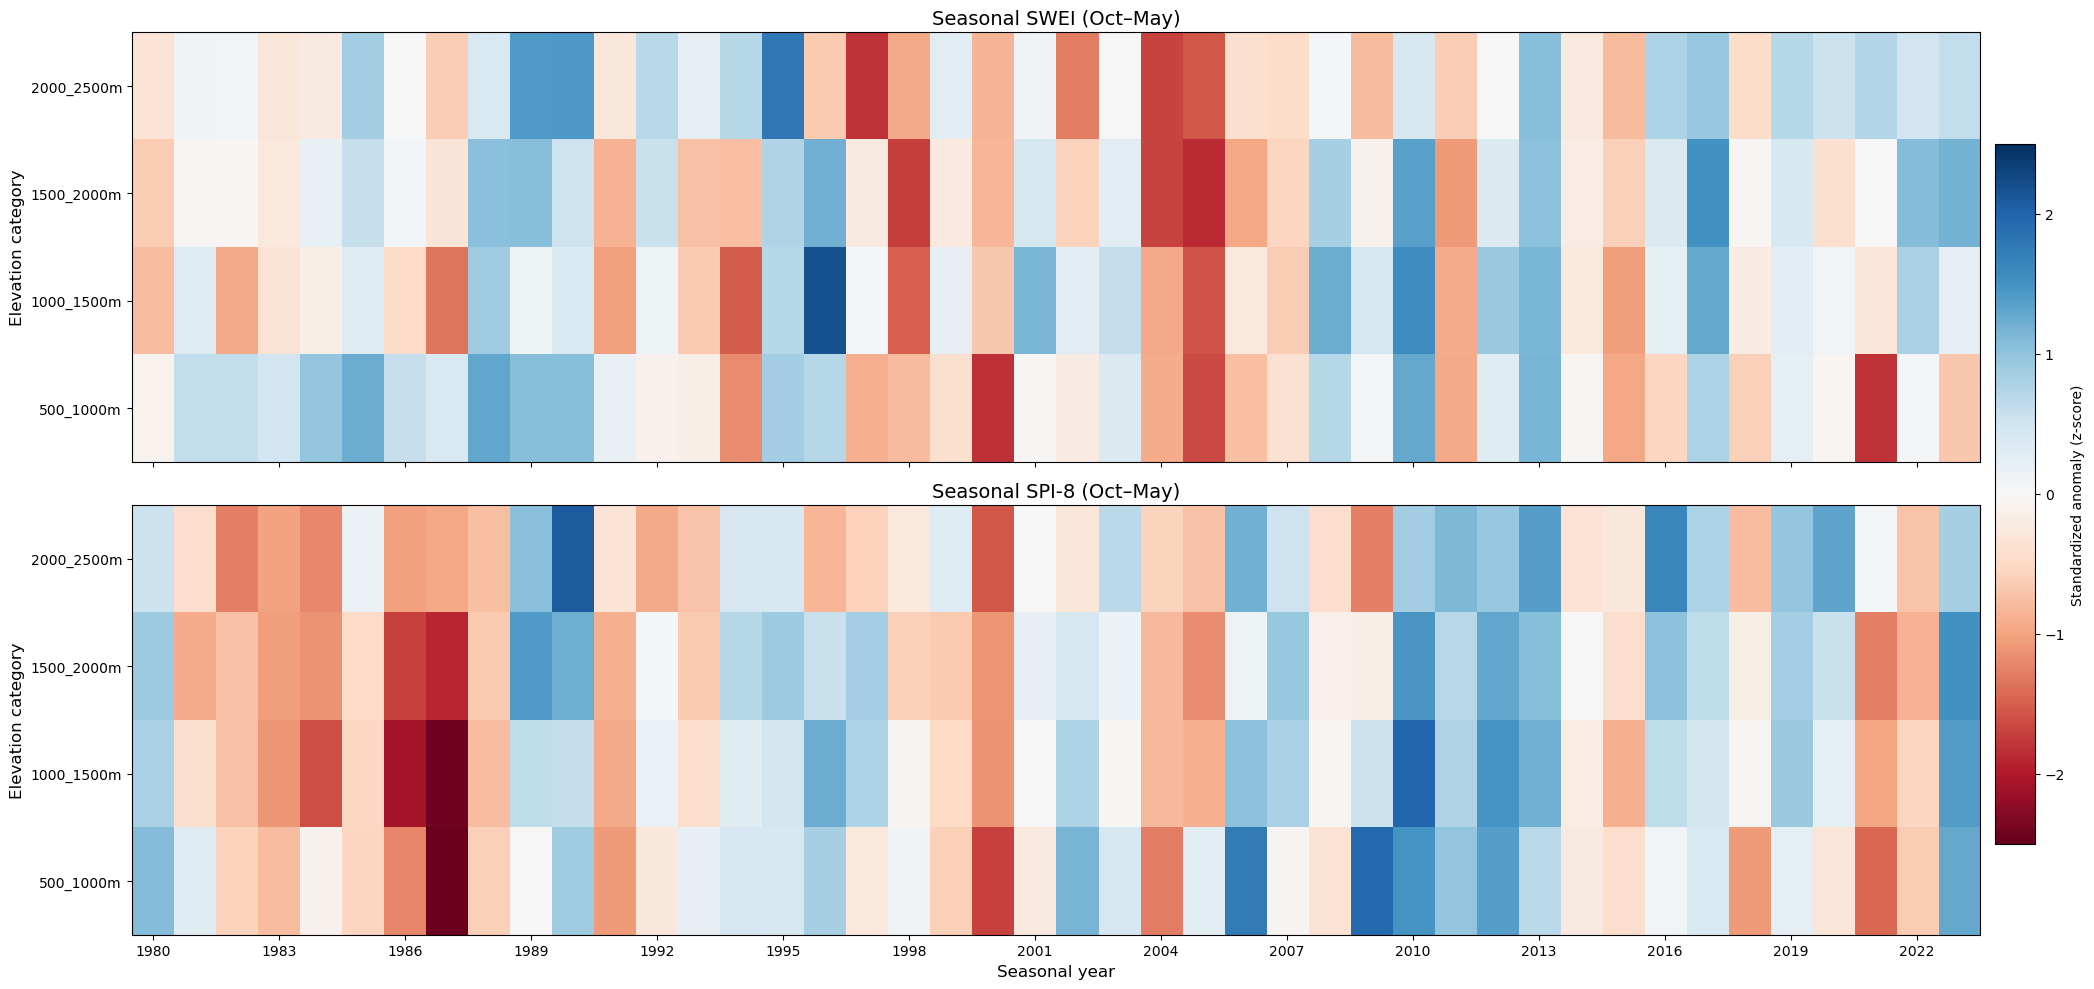

In [62]:
# Define elevation order explicitly
elev_order = ['2000_2500m','1500_2000m','1000_1500m','500_1000m']

# Pivot SPI
spi_mat = spi_8mo_avg.pivot_table(
    index="Elevation_Category",
    columns="Seasonal_Year",
    values="Avg_SPI_8mo"
).reindex(elev_order)

# Pivot SWEI
swei_mat = swei_8mo_avg.pivot_table(
    index="Elevation_Category",
    columns="Seasonal_Year",
    values="Avg_SWEI_8mo"
).reindex(elev_order)

# Keep only common years
common_years = sorted(set(spi_mat.columns).intersection(set(swei_mat.columns)))
spi_mat = spi_mat[common_years]
swei_mat = swei_mat[common_years]

# ---- Plot ----
fig, axes = plt.subplots(2, 1, figsize=(20, 10), sharex=True)

vlim = 2.5  # same scale for both

im1 = axes[0].imshow(swei_mat.values, aspect="auto",
                     cmap="RdBu", vmin=-vlim, vmax=vlim)
axes[0].set_title("Seasonal SWEI (Oct–May)", fontsize=14)
axes[0].set_ylabel("Elevation category", fontsize=12)
axes[0].set_yticks(np.arange(len(swei_mat.index)))
axes[0].set_yticklabels(swei_mat.index)

im2 = axes[1].imshow(spi_mat.values, aspect="auto",
                     cmap="RdBu", vmin=-vlim, vmax=vlim)
axes[1].set_title("Seasonal SPI-8 (Oct–May)", fontsize=14)
axes[1].set_ylabel("Elevation category", fontsize=12)
axes[1].set_xlabel("Seasonal year", fontsize=12)
axes[1].set_yticks(np.arange(len(spi_mat.index)))
axes[1].set_yticklabels(spi_mat.index)

# X-axis ticks (years)
years = common_years
step = max(1, len(years)//12)
axes[1].set_xticks(np.arange(len(years))[::step])
axes[1].set_xticklabels(years[::step])

# Shared colorbar on the right, outside the axes
# Place colorbar outside the main plot area
cbar_ax = fig.add_axes([1, 0.15, 0.02, 0.7])
cbar = fig.colorbar(im2, cax=cbar_ax)
cbar.set_label("Standardized anomaly (z-score)")

plt.tight_layout()
# save figure
out_file_heatmap = config['SWEI_plots'] / f'SWEI_SPI_bow_basin_8month_heatmap.png'
fig.savefig(out_file_heatmap, dpi=300, bbox_inches='tight')
plt.show()

In [59]:
# merge SWEI and SPI data for comparison
swei_spi_comparison = swei_8mo_avg.merge(
    spi_8mo_avg,
    on=['Elevation_Category', 'Seasonal_Year', 'month'],
    how='inner',
    suffixes=('_SWEI', '_SPI')
)
display(swei_spi_comparison)

,Elevation_Category,Seasonal_Year,month,Avg_SWEI_8mo,Avg_SPI_8mo
0,1000_1500m,1980,5,-0.778473,0.814199
1,1000_1500m,1981,5,0.320094,-0.394971
2,1000_1500m,1982,5,-0.942805,-0.728352
3,1000_1500m,1983,5,-0.356098,-1.105114
4,1000_1500m,1984,5,-0.147442,-1.615538
...,...,...,...,...,...
171,500_1000m,2019,5,0.225988,0.216493
172,500_1000m,2020,5,-0.047313,-0.306332
173,500_1000m,2021,5,-1.810268,-1.442903
174,500_1000m,2022,5,0.020820,-0.635333


In [65]:
# calculate difference between SWEI and SPI
swei_spi_comparison['SPI_minus_SWEI'] = swei_spi_comparison['Avg_SPI_8mo'] - swei_spi_comparison['Avg_SWEI_8mo']
display(swei_spi_comparison.head(15))

,Elevation_Category,Seasonal_Year,month,Avg_SWEI_8mo,Avg_SPI_8mo,SPI_minus_SWEI
0,1000_1500m,1980,5,-0.778473,0.814199,1.592672
1,1000_1500m,1981,5,0.320094,-0.394971,-0.715066
2,1000_1500m,1982,5,-0.942805,-0.728352,0.214453
3,1000_1500m,1983,5,-0.356098,-1.105114,-0.749016
4,1000_1500m,1984,5,-0.147442,-1.615538,-1.468096
5,1000_1500m,1985,5,0.314323,-0.523740,-0.838062
6,1000_1500m,1986,5,-0.474813,-2.081306,-1.606493
7,1000_1500m,1987,5,-1.338402,-2.430023,-1.091620
8,1000_1500m,1988,5,0.898300,-0.778585,-1.676884
9,1000_1500m,1989,5,0.113604,0.644117,0.530513


In [68]:
#max and min  values in the difference
max_diff = swei_spi_comparison['SPI_minus_SWEI'].max()
min_diff = swei_spi_comparison['SPI_minus_SWEI'].min()
print(f"Maximum SPI - SWEI difference: {max_diff}")
print(f"Minimum SPI - SWEI difference: {min_diff}")

Maximum SPI - SWEI difference: 2.4913449704342088
Minimum SPI - SWEI difference: -2.832189067804349


C:\Users\walimunige.rupasingh\AppData\Local\Temp\ipykernel_22696\448838917.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(years[::step])
C:\Users\walimunige.rupasingh\AppData\Local\Temp\ipykernel_22696\448838917.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


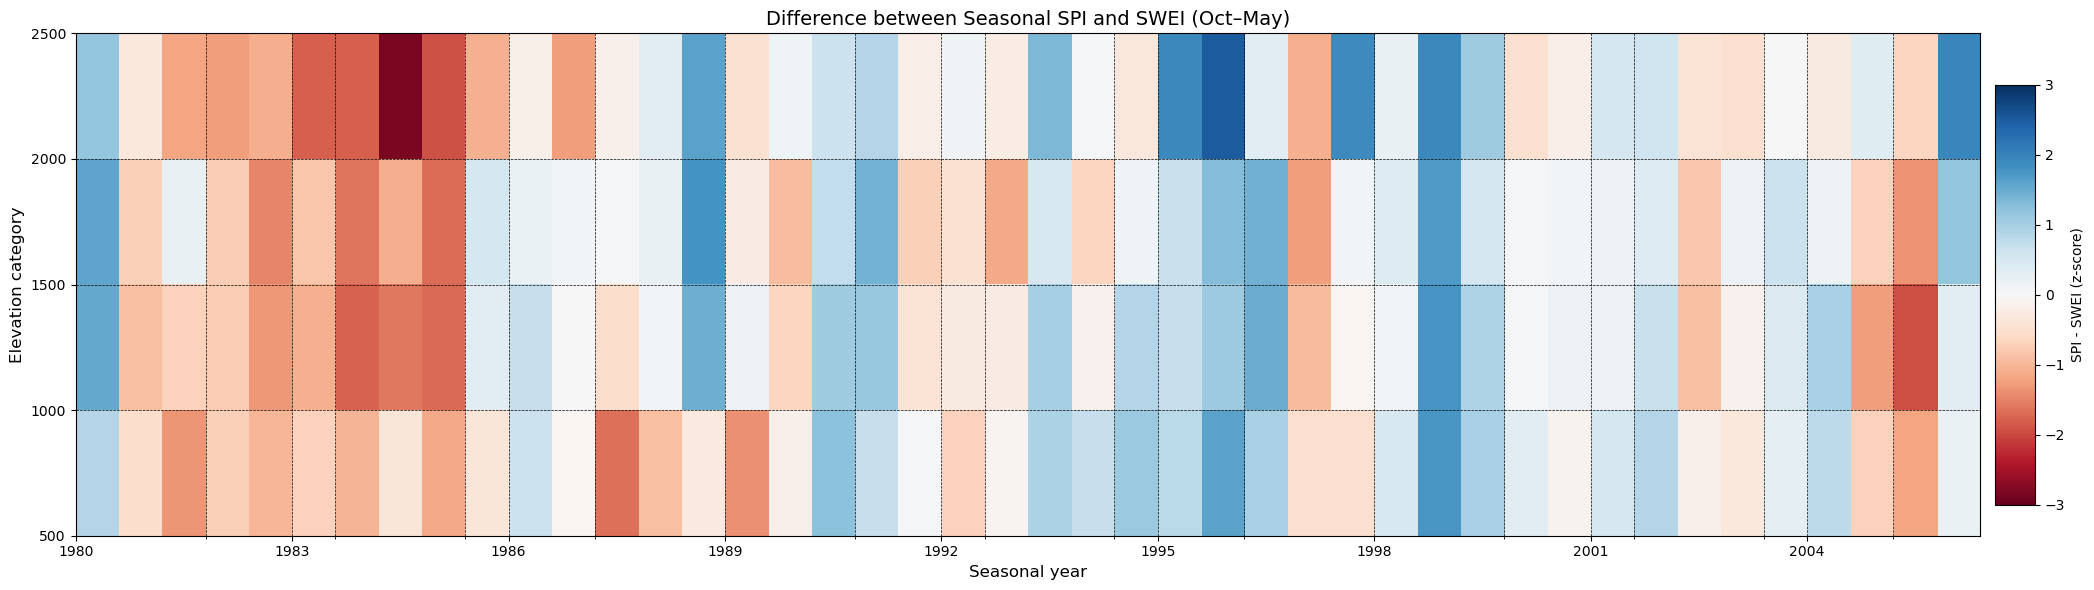

In [104]:
# plot heat map for the diffrence between SWEI and SPI

# Pivot SPI-SWEI
spi_swei_mat = swei_spi_comparison.pivot_table(
    index="Elevation_Category",
    columns="Seasonal_Year",
    values="SPI_minus_SWEI"
).reindex(elev_order)

# Single plot (reuse same axis for both references below)
fig, ax = plt.subplots(1, 1, figsize=(20, 6))
axes = np.array([ax, ax])  # axes[0] and axes[1] both point to the same Axes

# Years used for x-axis labelling
common_years = spi_swei_mat.columns.tolist()

vlim = 3 

im1 = axes[0].imshow(spi_swei_mat.values, aspect="auto",
                     cmap="RdBu", vmin=-vlim, vmax=vlim)
axes[0].set_title("Difference between Seasonal SPI and SWEI (Oct–May)", fontsize=14)
axes[0].set_ylabel("Elevation category", fontsize=12)
axes[0].set_yticks(np.arange(len(spi_swei_mat.index)))
axes[0].set_yticklabels(spi_swei_mat.index)

# Y-axis: numeric elevation ticks and dividing lines between categories
# Replot with explicit extent so that integer y positions are bin borders
n_elev = spi_swei_mat.shape[0]

# Older Matplotlib versions do not support `clear()` on ArtistList (axes[0].images),
# so we directly add a new image without attempting to clear the existing one.
im1 = axes[0].imshow(
    spi_swei_mat.values,
    aspect="auto",
    cmap="RdBu",
    vmin=-vlim,
    vmax=vlim,
    extent=[0, spi_swei_mat.shape[1], 0, n_elev],
    origin="upper",
)

# Tick positions at category boundaries (0..n_elev)
yticks = np.arange(n_elev + 1)
# Labels in meters at boundaries, increasing from 500 to 2500
ylabels = [500 * i for i in range(1, n_elev + 2)]

axes[0].set_yticks(yticks)
axes[0].set_yticklabels(ylabels)

# Horizontal grid lines at each elevation boundary
axes[0].grid(axis='y', color='black', linestyle='--', linewidth=0.5)

# X-axis ticks (years)
years = common_years
step = max(1, len(years)//12)
axes[1].set_xticks(np.arange(len(years))[::step],minor=True)
axes[1].set_xticklabels(years[::step])
axes[1].set_xlabel("Seasonal year", fontsize=12)
axes[1].grid(axis='x', which='both', color='black', linestyle='--', linewidth=0.5)

# Shared colorbar on the right, outside the axes
# Place colorbar outside the main plot area
cbar_ax = fig.add_axes([1, 0.15, 0.02, 0.7])
cbar = fig.colorbar(im1, cax=cbar_ax)
cbar.set_label("SPI - SWEI (z-score)")
plt.tight_layout()
# save figure
out_file_heatmap_diff = config['SWEI_plots'] / f'SWEI_minus_SPI_bow_basin_8month_heatmap.png'
fig.savefig(out_file_heatmap_diff, dpi=1000, bbox_inches='tight')
plt.show()

# Wilcoxon Signed Rank Test 

In [111]:
from scipy.stats import wilcoxon

for elev_cat, grp in swei_spi_comparison.groupby('Elevation_Category'):
    diff = grp['SPI_minus_SWEI']

    stat, p_value = wilcoxon(diff)

    print(f"Elevation category: {elev_cat}")
    print(f"  Wilcoxon statistic = {stat:.3f}")
    print(f"  p-value = {p_value:.4f}\n")

Elevation category: 1000_1500m
  Wilcoxon statistic = 491.000
  p-value = 0.9677

Elevation category: 1500_2000m
  Wilcoxon statistic = 482.000
  p-value = 0.8852

Elevation category: 2000_2500m
  Wilcoxon statistic = 486.000
  p-value = 0.9218

Elevation category: 500_1000m
  Wilcoxon statistic = 484.000
  p-value = 0.9035



In [110]:
z = stat / np.sqrt(len(diff))
r = abs(z) / np.sqrt(len(diff))
print(f"Effect size r = {r:.3f}")

Effect size r = 44.080


In [109]:
stat, p_value = wilcoxon(diff, alternative='greater')

print(f"p-value = {p_value:.4f}")

p-value = 0.5177


# Heldmuyer classification

In [35]:
# load data
SD_clasification_data = casr_data[['Grid_id', 'time', 'lon', 'lat', 'Elevation_Category', 'Seasonal_Year', 'SWE','Precipitation']]

display(SD_clasification_data.head())


,Grid_id,time,lon,lat,Elevation_Category,Seasonal_Year,SWE,Precipitation
0,1,1980-10-10,-116.1380,51.3346,2000_2500m,1980.0,0.878418,0.009879
2,2,1983-10-12,-116.1875,51.4191,2000_2500m,1983.0,6.875000,0.023846
3,2,1980-12-11,-116.1875,51.4191,2000_2500m,1980.0,118.125000,4.578907
5,2,1982-10-29,-116.1875,51.4191,2000_2500m,1982.0,23.125000,1.777088
6,2,1982-01-18,-116.1875,51.4191,2000_2500m,1981.0,145.000000,1.890419


In [36]:
# find peak SWE per each Grid point and Seasonala_Year
peak_idx = (
    SD_clasification_data
    .groupby(['Grid_id', 'Seasonal_Year'])['SWE']
    .idxmax()
)

peak_SWE_data = (
    SD_clasification_data
    .loc[peak_idx, ['Grid_id', 'Elevation_Category','lon','lat','Seasonal_Year', 'time', 'SWE']]
    .rename(columns={'time': 'Peak_SWE_Date', 'SWE': 'Peak_SWE'})
    .reset_index(drop=True)
)

display(peak_SWE_data.head())

,Grid_id,Elevation_Category,lon,lat,Seasonal_Year,Peak_SWE_Date,Peak_SWE
0,1,2000_2500m,-116.138,51.3346,1980.0,1981-05-12,240.625
1,1,2000_2500m,-116.138,51.3346,1981.0,1982-05-09,277.000
2,1,2000_2500m,-116.138,51.3346,1982.0,1983-04-11,273.875
3,1,2000_2500m,-116.138,51.3346,1983.0,1984-04-12,200.375
4,1,2000_2500m,-116.138,51.3346,1984.0,1985-04-29,227.750


In [37]:
# calculate meanpeak SWE per Elevation category and Seasonal Year
mean_peak_SWE = (
    peak_SWE_data
    .groupby(['Elevation_Category', 'Seasonal_Year'], as_index=False)
    .agg(Mean_Peak_SWE=('Peak_SWE', 'mean'))
)
display(mean_peak_SWE.head(15))

,Elevation_Category,Seasonal_Year,Mean_Peak_SWE
0,1000_1500m,1980.0,40.117253
1,1000_1500m,1981.0,29.995833
2,1000_1500m,1982.0,17.079167
3,1000_1500m,1983.0,30.662508
4,1000_1500m,1984.0,23.369173
5,1000_1500m,1985.0,33.612565
6,1000_1500m,1986.0,24.904169
7,1000_1500m,1987.0,25.312655
8,1000_1500m,1988.0,39.641667
9,1000_1500m,1989.0,30.152865


In [38]:
# compute climatological peak SWE per Elevation category 1991-2020
clim_peak_SWE = (
    mean_peak_SWE
    .loc[mean_peak_SWE['Seasonal_Year'].between(1991, 2020)]
    .groupby('Elevation_Category', as_index=False)
    .agg(Climatological_Peak_SWE=('Mean_Peak_SWE', 'mean'))
)   
display(clim_peak_SWE.head(10))

,Elevation_Category,Climatological_Peak_SWE
0,1000_1500m,33.787892
1,1500_2000m,47.861118
2,2000_2500m,145.828157
3,500_1000m,33.579055


In [39]:
# 5% of climatological peak SWE per Elevation category
clim_peak_SWE['onset_SWE'] = clim_peak_SWE['Climatological_Peak_SWE'] * 0.05
display(clim_peak_SWE.head(10))

,Elevation_Category,Climatological_Peak_SWE,onset_SWE
0,1000_1500m,33.787892,1.689395
1,1500_2000m,47.861118,2.393056
2,2000_2500m,145.828157,7.291408
3,500_1000m,33.579055,1.678953


In [40]:
# select data between peak_swe of the season and clim_peak_swe date for each grid and seasonal year

# Initialize an empty DataFrame to store the results
onset_to_peak = pd.DataFrame()

# Iterate through each coordinate_id
for coordinate_id in SD_clasification_data['Grid_id'].unique():
    # Filter the data for the current coordinate_id
    coord_data = SD_clasification_data[SD_clasification_data['Grid_id'] == coordinate_id]
    
    # Iterate through each season year for the current coordinate_id
    for year in coord_data['Seasonal_Year'].unique():
        # Filter the data for the current season year
        season_data = coord_data[coord_data['Seasonal_Year'] == year]
        
        # Get the elevation category for this group
        elev_cat = season_data['Elevation_Category'].iloc[0]

        # Get the correct threshold for this elevation category from clim_peak_SWE
        row = clim_peak_SWE.loc[
            clim_peak_SWE['Elevation_Category'] == elev_cat,
            'onset_SWE'
        ]
        if row.empty or pd.isna(row.iloc[0]):
            continue  # no threshold defined for this elevation band

        threshold = row.iloc[0]

        # Find the onset date (first date SWE >= threshold)
        onset_mask = season_data['SWE'] >= threshold
        if not onset_mask.any():
            continue  # no onset for this season/grid

        onset_date = season_data.loc[onset_mask, 'time'].min()
        
        # Find the peak date
        peak_date = season_data[season_data['SWE'] == season_data['SWE'].max()]['time'].values[0]
        
        # Select data from onset to peak
        selected_data = season_data[(season_data['time'] >= onset_date) & (season_data['time'] <= peak_date)]
        
        # Append the selected data to the result DataFrame
        onset_to_peak = pd.concat([onset_to_peak, selected_data])

# Reset the index of the result DataFrame
onset_to_peak.reset_index(drop=True, inplace=True)

# save the result to a CSV file
onset_to_peak.to_csv(config['classification_output_dir'] /  'onset_to_peak_data.csv', index=False)

# Display the result
display(onset_to_peak)


,Grid_id,time,lon,lat,Elevation_Category,Seasonal_Year,SWE,Precipitation
0,1,1981-02-11,-116.1380,51.3346,2000_2500m,1980.0,152.250000,0.000000
1,1,1980-11-07,-116.1380,51.3346,2000_2500m,1980.0,27.000000,2.128011
2,1,1980-12-21,-116.1380,51.3346,2000_2500m,1980.0,110.625000,3.271602
3,1,1980-10-25,-116.1380,51.3346,2000_2500m,1980.0,12.625000,0.000000
4,1,1980-11-13,-116.1380,51.3346,2000_2500m,1980.0,40.500000,0.007695
...,...,...,...,...,...,...,...,...
1427070,257,2022-11-08,-111.6202,50.0960,500_1000m,2022.0,23.125000,5.015135
1427071,257,2022-11-04,-111.6202,50.0960,500_1000m,2022.0,8.500000,0.026440
1427072,257,2022-10-24,-111.6202,50.0960,500_1000m,2022.0,0.625000,4.340502
1427073,257,2022-10-30,-111.6202,50.0960,500_1000m,2022.0,0.000061,0.001129


In [41]:
# take cum sum of Precipitation and mean SWE over each Seasonal_Year, per grid
SD_clasification_data = SD_clasification_data.sort_values(
    ['Grid_id', 'Seasonal_Year', 'time']
).copy()

SD_clasification_data['Cumulative_Precipitation'] = (
    SD_clasification_data
    .groupby(['Grid_id', 'Seasonal_Year'])['Precipitation']
    .cumsum()
)

# get max cumulative Precipitation and mean SWE for each grid and Seasonal_Year
seasonal_maxcumP_meanSWE = (
    SD_clasification_data
    .groupby(['Grid_id', 'Seasonal_Year', 'lon', 'lat', 'Elevation_Category'], as_index=False)
    .agg(
        Max_Cumulative_Precipitation=('Cumulative_Precipitation', 'max'),
        Mean_SWE=('SWE', 'mean')
    )
)

display(seasonal_maxcumP_meanSWE.head(15))

,Grid_id,Seasonal_Year,lon,lat,Elevation_Category,Max_Cumulative_Precipitation,Mean_SWE
0,1,1980.0,-116.138,51.3346,2000_2500m,330.692535,124.720065
1,1,1981.0,-116.138,51.3346,2000_2500m,321.687604,141.946829
2,1,1982.0,-116.138,51.3346,2000_2500m,231.587842,140.776336
3,1,1983.0,-116.138,51.3346,2000_2500m,272.967472,114.779913
4,1,1984.0,-116.138,51.3346,2000_2500m,258.220625,110.846370
5,1,1985.0,-116.138,51.3346,2000_2500m,366.266071,167.173256
6,1,1986.0,-116.138,51.3346,2000_2500m,304.387351,112.710529
7,1,1987.0,-116.138,51.3346,2000_2500m,296.970781,101.974434
8,1,1988.0,-116.138,51.3346,2000_2500m,353.303776,147.406806
9,1,1989.0,-116.138,51.3346,2000_2500m,420.539197,205.707166


In [42]:
mean_cumP_by_elev = seasonal_maxcumP_meanSWE.groupby('Elevation_Category')['Max_Cumulative_Precipitation'].mean().reset_index()
mean_cumP_by_elev = mean_cumP_by_elev.rename(columns={'Max_Cumulative_Precipitation': 'mean_max_cumulative_P'})

display(mean_cumP_by_elev)

,Elevation_Category,mean_max_cumulative_P
0,1000_1500m,198.749130
1,1500_2000m,254.095915
2,2000_2500m,322.630675
3,500_1000m,150.815091


In [43]:
# Merge the mean back to the main DataFrame
onset_to_peak_mean_filtered = seasonal_maxcumP_meanSWE.merge(
    mean_cumP_by_elev,
    on='Elevation_Category',
    how='left'
)

display(onset_to_peak_mean_filtered)

,Grid_id,Seasonal_Year,lon,lat,Elevation_Category,Max_Cumulative_Precipitation,Mean_SWE,mean_max_cumulative_P
0,1,1980.0,-116.1380,51.3346,2000_2500m,330.692535,124.720065,322.630675
1,1,1981.0,-116.1380,51.3346,2000_2500m,321.687604,141.946829,322.630675
2,1,1982.0,-116.1380,51.3346,2000_2500m,231.587842,140.776336,322.630675
3,1,1983.0,-116.1380,51.3346,2000_2500m,272.967472,114.779913,322.630675
4,1,1984.0,-116.1380,51.3346,2000_2500m,258.220625,110.846370,322.630675
...,...,...,...,...,...,...,...,...
11303,257,2019.0,-111.6202,50.0960,500_1000m,143.209873,2.395867,150.815091
11304,257,2020.0,-111.6202,50.0960,500_1000m,123.811036,2.383157,150.815091
11305,257,2021.0,-111.6202,50.0960,500_1000m,87.313718,1.164792,150.815091
11306,257,2022.0,-111.6202,50.0960,500_1000m,124.308624,3.057855,150.815091


In [44]:
# Calculations to plot graphs
onset_to_peak_mean_filtered['SWE_P_ratio'] = (
    onset_to_peak_mean_filtered['Mean_SWE'] /
    onset_to_peak_mean_filtered['Max_Cumulative_Precipitation']
)

onset_to_peak_mean_filtered['Cum_P_anomaly'] = (
    onset_to_peak_mean_filtered['Max_Cumulative_Precipitation'] -
    onset_to_peak_mean_filtered['mean_max_cumulative_P']
)

display(onset_to_peak_mean_filtered)

,Grid_id,Seasonal_Year,lon,lat,Elevation_Category,Max_Cumulative_Precipitation,Mean_SWE,mean_max_cumulative_P,SWE_P_ratio,Cum_P_anomaly
0,1,1980.0,-116.1380,51.3346,2000_2500m,330.692535,124.720065,322.630675,0.377148,8.061860
1,1,1981.0,-116.1380,51.3346,2000_2500m,321.687604,141.946829,322.630675,0.441257,-0.943071
2,1,1982.0,-116.1380,51.3346,2000_2500m,231.587842,140.776336,322.630675,0.607874,-91.042833
3,1,1983.0,-116.1380,51.3346,2000_2500m,272.967472,114.779913,322.630675,0.420489,-49.663203
4,1,1984.0,-116.1380,51.3346,2000_2500m,258.220625,110.846370,322.630675,0.429270,-64.410050
...,...,...,...,...,...,...,...,...,...,...
11303,257,2019.0,-111.6202,50.0960,500_1000m,143.209873,2.395867,150.815091,0.016730,-7.605218
11304,257,2020.0,-111.6202,50.0960,500_1000m,123.811036,2.383157,150.815091,0.019248,-27.004055
11305,257,2021.0,-111.6202,50.0960,500_1000m,87.313718,1.164792,150.815091,0.013340,-63.501373
11306,257,2022.0,-111.6202,50.0960,500_1000m,124.308624,3.057855,150.815091,0.024599,-26.506467


In [45]:
# take mean over Elevation_Category and Seasonal_Year
final_classification_data = (
    onset_to_peak_mean_filtered
    .groupby(['Elevation_Category', 'Seasonal_Year'], as_index=False)
    .agg(
        Avg_SWE_P_ratio=('SWE_P_ratio', 'mean'),
        Avg_Cum_P_anomaly=('Cum_P_anomaly', 'mean')
    )
)
display(final_classification_data)


,Elevation_Category,Seasonal_Year,Avg_SWE_P_ratio,Avg_Cum_P_anomaly
0,1000_1500m,1980.0,0.017906,43.262353
1,1000_1500m,1981.0,0.043095,-27.718914
2,1000_1500m,1982.0,0.027718,-41.953832
3,1000_1500m,1983.0,0.037195,-60.798274
4,1000_1500m,1984.0,0.054673,-81.752093
...,...,...,...,...
171,500_1000m,2019.0,0.064201,6.390565
172,500_1000m,2020.0,0.055116,-20.490437
173,500_1000m,2021.0,0.022948,-64.660087
174,500_1000m,2022.0,0.067483,-35.670494


K - Mean Clustering

In [46]:
# Standardize cumulative_P_anomaly and mean_SWE/cumulative_P for each elevation category
final_classification_data['cum_P_anomaly_z'] = final_classification_data.groupby('Elevation_Category')['Avg_Cum_P_anomaly'].transform(
    lambda x: (x - x.mean()) / x.std()
)
final_classification_data['Avg_SWE_P_ratio_z'] = final_classification_data.groupby('Elevation_Category')['Avg_SWE_P_ratio'].transform(
    lambda x: (x - x.mean()) / x.std()
)

display(final_classification_data)

,Elevation_Category,Seasonal_Year,Avg_SWE_P_ratio,Avg_Cum_P_anomaly,cum_P_anomaly_z,Avg_SWE_P_ratio_z
0,1000_1500m,1980.0,0.017906,43.262353,0.817975,-1.268619
1,1000_1500m,1981.0,0.043095,-27.718914,-0.524090,0.261404
2,1000_1500m,1982.0,0.027718,-41.953832,-0.793234,-0.672605
3,1000_1500m,1983.0,0.037195,-60.798274,-1.149532,-0.096961
4,1000_1500m,1984.0,0.054673,-81.752093,-1.545713,0.964706
...,...,...,...,...,...,...
171,500_1000m,2019.0,0.064201,6.390565,0.133418,-0.212730
172,500_1000m,2020.0,0.055116,-20.490437,-0.427786,-0.325934
173,500_1000m,2021.0,0.022948,-64.660087,-1.349932,-0.726735
174,500_1000m,2022.0,0.067483,-35.670494,-0.744706,-0.171839


In [47]:
# K-means clustering for the whole drought dataset (no elevation separation)
cluster_features = final_classification_data[['Avg_SWE_P_ratio_z', 'cum_P_anomaly_z']]
kmean = KMeans(n_clusters=4, random_state=0)
final_classification_data['cluster'] = kmean.fit_predict(cluster_features)
print("Cluster centers:\n", kmean.cluster_centers_)

display(final_classification_data.head(15))

c:\Users\walimunige.rupasingh\AppData\Local\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Cluster centers:
 [[-0.6673522   0.9721895 ]
 [-0.46971655 -0.58818805]
 [ 1.35965984 -0.93399236]
 [ 0.84998336  1.03179308]]


c:\Users\walimunige.rupasingh\AppData\Local\miniconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:131: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\walimunige.rupasingh\AppData\Local\miniconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 255, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


,Elevation_Category,Seasonal_Year,Avg_SWE_P_ratio,Avg_Cum_P_anomaly,cum_P_anomaly_z,Avg_SWE_P_ratio_z,cluster
0,1000_1500m,1980.0,0.017906,43.262353,0.817975,-1.268619,0
1,1000_1500m,1981.0,0.043095,-27.718914,-0.524090,0.261404,1
2,1000_1500m,1982.0,0.027718,-41.953832,-0.793234,-0.672605,1
3,1000_1500m,1983.0,0.037195,-60.798274,-1.149532,-0.096961,1
4,1000_1500m,1984.0,0.054673,-81.752093,-1.545713,0.964706,2
5,1000_1500m,1985.0,0.057626,-33.884591,-0.640667,1.144106,2
6,1000_1500m,1986.0,0.069102,-98.322066,-1.859007,1.841164,2
7,1000_1500m,1987.0,0.045110,-111.027008,-2.099223,0.383803,2
8,1000_1500m,1988.0,0.076778,-46.511923,-0.879416,2.307439,2
9,1000_1500m,1989.0,0.036765,35.264678,0.666761,-0.123096,0


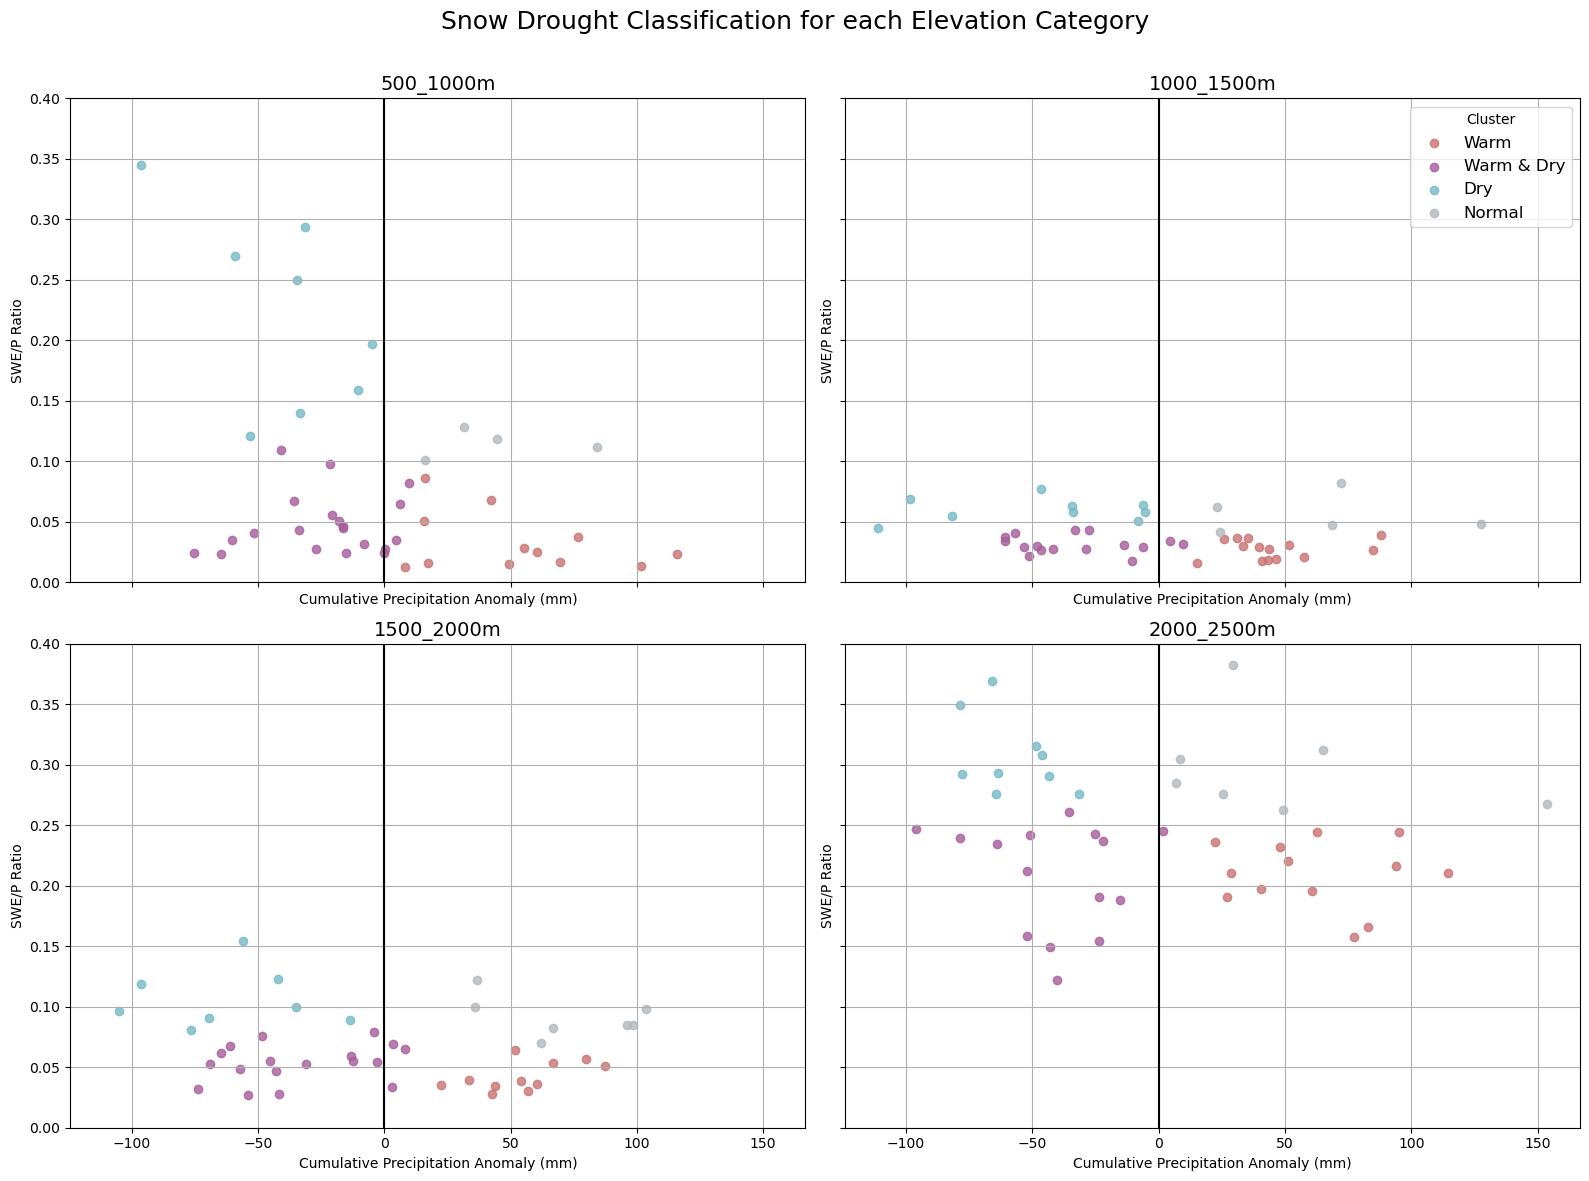

In [105]:
# Define cluster colors for plotting
cluster_colors = {
    "Warm": "#C97272",         # orange
    "Warm & Dry": "#A75D9B",   # reddish
    "Dry": "#76B9C5",          # blue
    "Normal": "#B2B8BD"       # grey for non-drought years    
    # Add more cluster names and colors as needed
}

# Map cluster numbers to cluster names
cluster_number_to_name = {0: "Warm", 1: "Warm & Dry", 2:  "Dry", 3: "Normal"}
final_classification_data['cluster_name'] = final_classification_data['cluster'].map(cluster_number_to_name)

# Create subplots for each elevation category
elevations = final_classification_data['Elevation_Category'].unique()
fig, axes = plt.subplots(2, 2, figsize=(16, 12), sharex=True, sharey=True)
axes = axes.flatten()

# Define desired elevation order
elev_order = ['500_1000m', '1000_1500m', '1500_2000m', '2000_2500m']
elevations_ordered = [e for e in elev_order if e in elevations]

for i, elev in enumerate(elevations_ordered):
    ax = axes[i]
    drought_subset = final_classification_data[
        final_classification_data['Elevation_Category'] == elev
    ]

    for cname, color in cluster_colors.items():
        cluster_points = drought_subset[drought_subset['cluster_name'] == cname]
        ax.scatter(
            cluster_points['Avg_Cum_P_anomaly'],
            cluster_points['Avg_SWE_P_ratio'],
            color=color,
            label=cname if i == 0 else "",  # Only label once for legend
            alpha=0.8
        )

    ax.axvline(0, color='black', linewidth=1.5, linestyle='-')
    ax.set_title(f'{elev}', fontsize=14)
    ax.set_xlabel('Cumulative Precipitation Anomaly (mm)')
    ax.set_ylabel('SWE/P Ratio')
    ax.grid(True)

# Add legend to the first subplot only
handles, labels = axes[0].get_legend_handles_labels()
# Place legend inside the top right subplot (axes[1])
axes[1].legend(handles, labels, title='Cluster', loc='upper right', fontsize=12)
plt.suptitle('Snow Drought Classification for each Elevation Category', fontsize=18)
plt.ylim(0,0.4)
plt.savefig(config['classification_plots'] / 'Snow_Drought_Classification_by_Elevation.png', dpi=300, bbox_inches='tight')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

In [75]:
# add season year for each cluster and elevation category to a summary table
 
# add season year for each cluster and elevation category to a summary table
 
name_to_col = {
    "Dry": "dry",
    "Warm & Dry": "dry&warm",
    "Warm": "warm",
    "Normal": "normal",
}

cluster_rows = []
for elev in elevations_ordered:
    drought_subset = final_classification_data[
        final_classification_data['Elevation_Category'] == elev
    ]
    row = {"Elevation_Category": elev}
    for cname, col in name_to_col.items():
        years = (
            drought_subset.loc[drought_subset['cluster_name'] == cname, 'Seasonal_Year']
            .dropna()
            .astype(int)
            .unique()
        )
        row[col] = sorted(years.tolist())
    cluster_rows.append(row)

sd_years_df = pd.DataFrame(cluster_rows)
display(sd_years_df)



,Elevation_Category,dry,dry&warm,warm,normal
0,500_1000m,"[1982, 1984, 1985, 1986, 1987, 1988, 1989, 1991]","[1981, 1983, 1992, 1993, 1997, 1998, 1999, 200...","[1980, 1994, 1996, 2002, 2003, 2005, 2006, 200...","[1990, 1995, 2010, 2013]"
1,1000_1500m,"[1984, 1985, 1986, 1987, 1988, 2001, 2003, 200...","[1981, 1982, 1983, 1991, 1992, 1993, 1998, 199...","[1980, 1989, 1990, 1994, 1997, 2002, 2006, 200...","[1995, 1996, 2010, 2013, 2017]"
2,1500_2000m,"[1984, 1985, 1986, 1987, 1988, 2008, 2021, 2022]","[1981, 1982, 1983, 1991, 1992, 1993, 1998, 199...","[1980, 1990, 1994, 1997, 2002, 2007, 2011, 201...","[1989, 1995, 1996, 2010, 2013, 2017, 2023]"
3,2000_2500m,"[1981, 1982, 1983, 1984, 1986, 1988, 1992, 199...","[1987, 1991, 1996, 1997, 1998, 2000, 2001, 200...","[1980, 1999, 2003, 2006, 2007, 2010, 2011, 201...","[1985, 1989, 1990, 1994, 1995, 2017, 2021]"


C:\Users\walimunige.rupasingh\AppData\Local\Temp\ipykernel_22696\2553234361.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


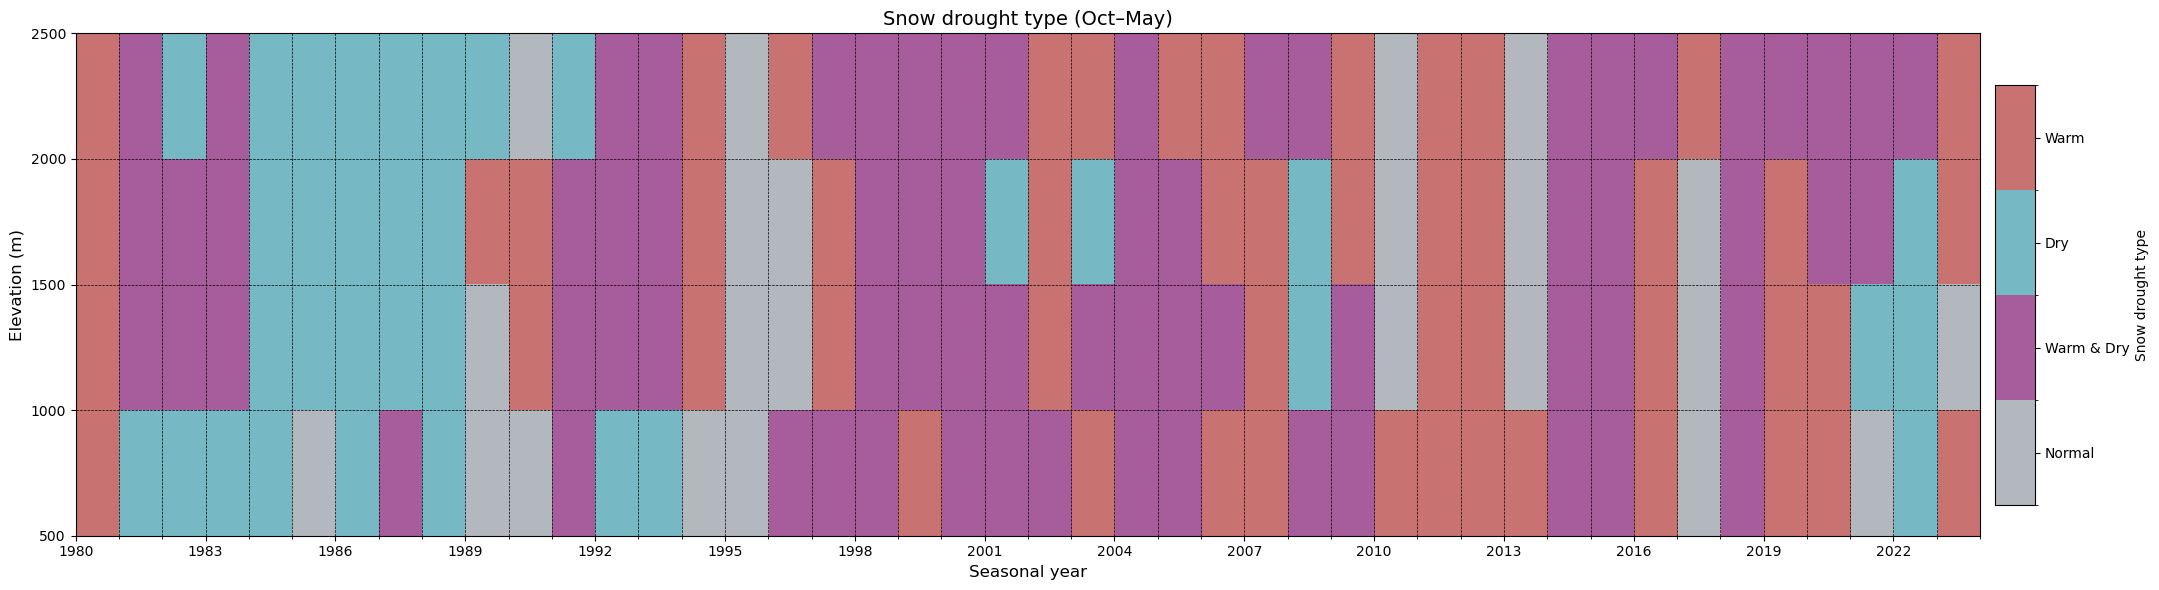

In [106]:
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap, BoundaryNorm

# Elevation order (bottom → top)
elev_order = [
    "500_1000m",
    "1000_1500m",
    "1500_2000m",
    "2000_2500m"
]

years_arr = np.array(years)

# Initialize matrix with "normal" (0)
sd_matrix = np.zeros((len(elev_order), len(years_arr)), dtype=int)

# Map cluster-summary columns to integer codes
category_codes = {
    "dry": 2,
    "dry&warm": 1,
    "warm": 3,
    "normal": 0
}

for i, elev in enumerate(elev_order):
    row = sd_years_df[sd_years_df["Elevation_Category"] == elev].iloc[0]
    for category, code in category_codes.items():
        for y in row[category]:
            if y in years_arr:
                j = np.where(years_arr == y)[0][0]
                sd_matrix[i, j] = code

# ---- Plot (style similar to SWEI−SPI difference heatmap) ----
fig, ax = plt.subplots(1, 1, figsize=(20, 6))
axes = np.array([ax, ax])  # axes[0] and axes[1] both point to the same Axes

n_elev, n_years = sd_matrix.shape

# Discrete colormap for the four cluster types in code order: 0,1,2,3
cmap = ListedColormap([
    cluster_colors["Normal"],      # 0
    cluster_colors["Warm & Dry"],  # 1
    cluster_colors["Dry"],         # 2
    cluster_colors["Warm"],        # 3
])
bounds = [-0.5, 0.5, 1.5, 2.5, 3.5]
norm = BoundaryNorm(bounds, cmap.N)

im = axes[0].imshow(
    sd_matrix,
    aspect="auto",
    cmap=cmap,
    norm=norm,
    extent=[0, n_years, 0, n_elev],
    origin="upper",
)

axes[0].set_title("Snow drought type (Oct–May)", fontsize=14)
axes[0].set_ylabel("Elevation (m)", fontsize=12)

# Y-axis: numeric elevation ticks and dividing lines between categories
yticks = np.arange(n_elev + 1)
ylabels = [500 * i for i in range(1, n_elev + 2)]
axes[0].set_yticks(yticks)
axes[0].set_yticklabels(ylabels)
axes[0].grid(axis='y', color='black', linestyle='--', linewidth=0.5)

# X-axis ticks (years)
step = max(1, len(years_arr) // 12)
axes[1].set_xticks(np.arange(0, n_years, step))
axes[1].set_xticklabels(years_arr[::step])
axes[1].set_xlabel("Seasonal year", fontsize=12)
axes[1].set_xticks(np.arange(0, n_years + 1, 1), minor=True)
axes[1].grid(axis='x', which='both', color='black', linestyle='--', linewidth=0.5)

# Colorbar on the right, outside the axes
cbar_ax = fig.add_axes([1, 0.15, 0.02, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax, boundaries=bounds, ticks=[0, 1, 2, 3])
cbar.ax.set_yticklabels(["Normal", "Warm & Dry", "Dry", "Warm"])
cbar.set_label("Snow drought type")

plt.tight_layout()
out_file_sd_heatmap = config['classification_plots'] / 'Snow_drought_type_by_elevation_heatmap.png'
fig.savefig(out_file_sd_heatmap, dpi=300, bbox_inches='tight')
plt.show()